# Main Model for Handwritten Text Synthesis GAN

This model will consist of 4 major networks, following the general architecture of an GAN.

1. Encoder: Produces an embedding that will be concatenated with the noise vector.
2. Generator: Taking noise vector as input and the text embedding to produce an 128x2048 image.
3. Discriminator: Trained alternating with generator input and ground-truth input, binary classification real or fake.
4. Recognizer: Taking image as input, produce a vector representation of the text.

## Import the required libraries:

In [1]:
import csv
import datetime
import os
import random
import re

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch_fidelity
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.utils.spectral_norm import spectral_norm
from torch.utils.data import DataLoader, Dataset, RandomSampler, Subset, random_split
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import Grayscale, Resize, ToTensor
from torchvision.transforms.functional import InterpolationMode

## Data Loading

### Helper Functions (Run once only to format data)

In [2]:
SCALE_HEIGHT = 32
SCALE_WIDTH = SCALE_HEIGHT*16

def preprocess_lines(data_root):
    """
    Creates a new `.txt` file `lines_improved.txt` that will be used
    for querying. This new `.txt` file contains all info necessary
    for the functionality of this project.
    """

    original_path = os.path.join(data_root, "lines.txt")
    improved_path = os.path.join(data_root, "lines_improved.txt")
    fi = open(improved_path, "w")

    # Some variables for tracking
    num_samples = 0
    valid_samples = 0
    
    # Loop through "lines.txt"
    with open(original_path, "r") as fo:
        headers = ["image_id", "image_path", "image_pt_path", "graylevel", "original_height", "original_width", "transcription", "transcription_len"]

        # First write the headers at the top of the file
        fi.writelines("\t".join(headers) + "\n")

        # Skip the intro stuff
        for line in fo.readlines():
            if line.startswith("#"):
                continue

            # Valid lines, not the intro_text
            line_items = line.strip().split(" ")  # `strip()` to remove newlines

            # The actual items (we extract the important ones)
            image_id = line_items[0]
            status = line_items[1]
            graylevel = int(line_items[2])
            transcription = " ".join(line_items[8:])  # Some data has whitespace, we join string till the end

            # Skip error images
            if status == "err":
                continue
        
            # Alphanumeric + common punctuation regex
            # Returns None if no match
            # 26 + 26 + 10 + 9 + 1 = 72
            # Spaces might be included as well
            # Punctuation include , ! ? ' " , : ; -
            if re.fullmatch("[a-zA-Z0-9.!?'\",:;| -]*", transcription) is None:
                continue

            # Now we have valid transcription
            num_samples += 1

            # We get the `.png` image path
            inp = image_id.split("-")  # `inp` stands for image name parts
            image_path_head = os.path.join(data_root, "lines", inp[0], f"{inp[0]}-{inp[1]}")
            image_path_tail = f"{image_id}.png"
            image_path = os.path.join(image_path_head, image_path_tail)
            
            # Read image, gets its dimensions, perform processing operations, and other stuff
            tmp_image = cv.imread(os.path.join(image_path_head, image_path_tail), cv.IMREAD_GRAYSCALE)  # Removes the channel dimension
            height, width = tmp_image.shape

            # Scaling calculations
            # If width * scale >= desired length (>= to be safe)
            # Condition here to speed up overall processing time
            if width * (SCALE_HEIGHT/height) >= SCALE_WIDTH:
                continue

            resized_tensor = process_image(tmp_image, graylevel)
            image_pt_path = os.path.join(image_path_head, f"{image_id}.pt")
            torch.save(resized_tensor, image_pt_path)

            # A fully valid image
            # Separate by underscores because `transcription` has spaces so we can't split by spaces
            fi.writelines(f"{image_id}\t{image_path}\t{image_pt_path}\t{graylevel}\t{height}\t{width}\t{transcription}\t{len(transcription)}\n")
            valid_samples += 1
        
        fi.close()
    
    print("# samples:", num_samples)
    print("Valid samples:", valid_samples)


def process_image(cv_image, graylevel):
    """
    Takes in a grayscale image that OpenCV read of shape (H, W) of type uint8
    Returns a PyTorch tensor of shape (1, 32, W'), where W' is the scaled width
    This tensor is padded and effectively thresholded
    """

    # Scaling factor
    height, width = cv_image.shape
    scale = SCALE_HEIGHT/height
    scaled_width = int(width*scale)

    # Trick here is to apply threshold before resize and padding
    # This allows OpenCV resizing to create a cleaner output image
    # 2nd return value is the thresholded image
    output = cv.threshold(cv_image, graylevel, 255, cv.THRESH_BINARY)[1]

    # INTER_AREA recommended for sizing down
    output = cv.resize(output, (scaled_width, SCALE_HEIGHT), interpolation=cv.INTER_AREA)

    # Turn it back to a tensor and map to [0, 1]
    output = torch.from_numpy(output).unsqueeze(0).type(torch.float32)
    output = (output-output.min()) / (output.max()-output.min())
    
    # Add padding
    _, _, resized_height = output.shape
    padding_to_add = SCALE_WIDTH - resized_height
    output = F.pad(output, (0, padding_to_add), value=1.0)

    return output

# Uncomment this if your data isn't processed yet
preprocess_lines("./data/")

### Important Dict (Run everytime before training)

In [3]:
# Sorted by ascii code
valid = [
    ' ', '!', '"', "'", ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
    ':', ';', '?', 
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
# Enumerate from 1 to save space for padding
char_to_int = {v: i for i, v in enumerate(valid, 1)}
int_to_char = {i: v for i, v in enumerate(valid, 1)}

In [4]:
class LineDataset(Dataset):
    def __init__(self, lines_improved_dir, ty=None):
        """
        params:
            lines_improved_dir: path to the `lines_improved.txt` file
            ty: type of the dataset "txt", "img" for text dataset or image dataset.
        """
        
        # Dataframe containing the stuff in `lines_improved.txt`
        self.lines_df = pd.read_csv(lines_improved_dir, sep="\t", quoting=csv.QUOTE_NONE)

        # Class properties
        self.ty = ty  # Type of dataset (lines, images, or both)
        self.max_transcription_len = max(self.lines_df["transcription_len"])

        # Temp variables...
        length = self.lines_df.shape[0]
        line_datas = self.lines_df.iloc
        ret_texts = [line_datas[i]["transcription"].replace('|', ' ') for i in range(length)]
        ret_ctois = [torch.tensor([char_to_int[char] for char in ret_texts[i]]) for i in range(length)]

        # ...for the important data
        if self.ty in ("txt", None):  # Added this condition to speed thigns up if only text
            self.ret_ctoi_paddeds = [F.pad(ret_ctois[i], pad=(0, self.max_transcription_len-len(ret_ctois[i]))) for i in range(length)]
        if self.ty in ("img", None):
            self.ret_images = [torch.load(line_datas[i]["image_pt_path"]) for i in range(length)]

    def __len__(self):
        return len(self.lines_df)
    
    def __getitem__(self, index):
        # Different type of individual loaders
        if self.ty == "txt":
            return self.ret_ctoi_paddeds[index]
        elif self.ty == "img":
            return self.ret_images[index]
        else:
            return self.ret_images[index], self.ret_ctoi_paddeds[index]

In [5]:
line_transcription_dataset = LineDataset("./data/lines_improved.txt", ty="txt")
line_image_dataset = LineDataset("./data/lines_improved.txt", ty="img")
line_dataset = LineDataset("./data/lines_improved.txt")

# Don't change this, we want to maintain consistent split
torch.manual_seed(12345678)  # DO NOT REMOVE THIS LINE
line_transcription_dataset_train, line_transcription_dataset_val = random_split(line_transcription_dataset, [0.8, 0.2])
line_image_dataset_train, line_image_dataset_val = random_split(line_image_dataset, [0.8, 0.2])
line_dataset_train, line_dataset_val = random_split(line_dataset, [0.8, 0.2])

# To train on a small dataset
line_transcription_dataset_train = Subset(line_transcription_dataset_train, range(100))
line_transcription_dataset_val = Subset(line_transcription_dataset_val, range(20))

line_image_dataset_train = Subset(line_image_dataset_train, range(100))
line_image_dataset_val = Subset(line_image_dataset_val, range(20))

# line_transcription_dataset_train, line_transcription_dataset_val, _ = random_split(line_transcription_dataset, [0.005, 0.005, 0.99])
# line_image_dataset_train, line_image_dataset_val, _ = random_split(line_image_dataset, [0.005, 0.005, 0.99])
# line_dataset_train, line_dataset_val = random_split(line_dataset, [0.0025, 0.9975])

print("lines")
print(len(line_transcription_dataset_train), len(line_transcription_dataset_val))
print("images")
print(len(line_image_dataset_train), len(line_image_dataset_val))
print("both")
print(len(line_dataset_train), len(line_dataset_val))


lines
100 20
images
100 20
both
5708 1427


In [6]:
# image, label = line_dataset_train[283]
# print(image.shape)
# plt.title("".join([int_to_char[int(val)] for val in label[label.nonzero()]]))
# print(image.squeeze(0).shape)
# plt.imshow(image.squeeze(0), cmap='gray')
# label, "".join([int_to_char[int(val)] for val in label[label.nonzero()]])
# # line_dataset.lines_df.iloc[798]
# print(image)

In [7]:
# # plt.imshow(line_dataset.lines_df["image_path"])
# image = read_image(line_dataset.lines_df["image_path"].iloc[283]).squeeze(0)
# plt.imshow(image, cmap="gray")

In [8]:
# plt.imshow(line_image_dataset[1000], cmap="gray")

In [9]:
# for i in DataLoader(line_image_dataset, batch_size=64, shuffle=True):
#     print(i.shape)
#     ...

Define Key Functions

In [10]:
"""Dataloading Functions"""
"""Datasaving Functions"""

"""Plotting Functions"""
"""Evaluation Functions"""
def calculate_gan_loss_and_accuracies(generator, encoder, discriminator, recognizer, 
                                  real_image_loader, input_text_loader, 
                                  batch_size=64, adversarial_loss_function=nn.BCELoss(), recognizer_loss_function=nn.CTCLoss(),
                                  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Calculates the loss for the GAN
    
    Params:
        generator: The generator model
        encoder: The encoder model
        discriminator: The discriminator model
        recognizer: The recognizer model
        real_image_loader: The dataloader for real images
        input_text_loader: The dataloader for input text
        batch_size: The batch size to use
        adversarial_loss_function: The adversarial loss function to use
        recognizer_loss_function: The recognizer loss function to use

    Returns:
        generator_and_encoder_loss: The loss for the generator and encoder
        discriminator_loss: The loss for the discriminator
    """
    fid = FrechetInceptionDistance(feature=2048, reset_real_features=False)
    for real_image_batch in real_image_loader:
        fid.update((real_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=True)

    generator_and_encoder_loss = 0
    discriminator_loss = 0
    discriminator_accuracy = 0
    with torch.no_grad():
        for i, (real_image_batch, input_text_batch) in enumerate(zip(real_image_loader, input_text_loader)):
            real_image_batch = real_image_batch.to(device)
            input_text_batch = input_text_batch.to(device)

            # generate noise of N x noise_dim
            noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)

            # Use encoder and generator to generate fake images
            text_embedding = encoder(input_text_batch)
            fake_image_batch = generator(noise, text_embedding)

            # train discriminator
            discriminator_output_for_real_images = discriminator(real_image_batch)
            discriminator_output_for_fake_images = discriminator(fake_image_batch)
            label_for_real_images = torch.ones_like(discriminator_output_for_real_images).to(device)
            label_for_fake_images = torch.zeros_like(discriminator_output_for_fake_images).to(device)
            real_images_loss = adversarial_loss_function(discriminator_output_for_real_images, label_for_real_images)
            fake_images_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_fake_images)
            discriminator_loss = (real_images_loss + fake_images_loss) / 2
            discriminator_loss += discriminator_loss.item()
            discriminator_accuracy += (torch.sum(discriminator_output_for_real_images >= 0.5).item() + torch.sum(discriminator_output_for_fake_images < 0.5).item()) / (2 * batch_size)

            # train generator
            
            adversarial_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_real_images)
            # recognizer_outputs = recognizer(fake_image_batch)
            # recognizer_loss = recognizer_loss_function(recognizer_outputs, input_text_batch)
            
            # balance the losses from different sources, according to https://arxiv.org/pdf/1903.00277.pdf
            adversarial_loss_mean, adversarial_loss_std = torch.mean(adversarial_loss), torch.std(adversarial_loss)
            # recognizer_loss_mean, recognizer_loss_std = torch.mean(recognizer_loss), torch.std(recognizer_loss)
            # recognizer_loss = loss_balancing_alpha * (adversarial_loss_std / recognizer_loss_std) * (recognizer_loss - recognizer_loss_mean) + adversarial_loss_mean
            
            generator_loss = adversarial_loss #+ recognizer_loss
            generator_and_encoder_loss += generator_loss.item()

            # calculate fid
            fid.update((real_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=True)
            fid.update((fake_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=False)

    generator_and_encoder_error = fid.compute().item()
    fid.reset()
    discriminator_accuracy /= len(real_image_loader)
    generator_and_encoder_loss /= len(real_image_loader)
    discriminator_loss /= len(input_text_loader)

    return generator_and_encoder_loss, discriminator_loss, generator_and_encoder_error, discriminator_accuracy

"""Training Functions"""
def train_recognizer(recognizer, train_line_loader, val_line_loader, batch_size=64, learning_rate=2e-4, betas=(0, 0.999), num_epochs=30):
    # only train on real images
    # also save model, plot graphs, save graphs
    pass

def train_gan(generator, encoder, discriminator, recognizer, 
              train_real_image_dataset, val_real_image_dataset, 
              train_input_text_dataset, val_input_text_dataset, 
              batch_size=64, learning_rate=2e-4, betas=(0, 0.999), num_epochs=30, loss_balancing_alpha=1):
    # Note, the generator and discriminator should be spectrally normalized before training
    # TODO: load dataloader with batch size batch_size

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cpu')
    print(device)
    generator = generator.to(device)
    encoder = encoder.to(device)
    discriminator = discriminator.to(device)
    # recognizer.to(device)
    
    train_real_image_loader = DataLoader(train_real_image_dataset, batch_size=batch_size, shuffle=True)
    val_real_image_loader = DataLoader(val_real_image_dataset, batch_size=batch_size, shuffle=True)
    train_input_text_loader = DataLoader(train_input_text_dataset, batch_size=batch_size, shuffle=True)
    val_input_text_loader = DataLoader(val_input_text_dataset, batch_size=batch_size, shuffle=True)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, betas=betas)
    generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)
    
    adversarial_loss_function = nn.BCELoss()  # discriminator already has sigmoid
    # recognizer_loss_function = nn.CTCLoss()  # TODO ensure recognizer's output fits the input of this loss function
    saving_filenames = {
        "encoder": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_encoder"),
        "generator": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_generator"),
        "discriminator": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_discriminator"), 
        "losses": os.path.join("main_model", "model_training_information", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_losses"),
        "accuracies": os.path.join("main_model", "model_training_information", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_accuracies")
        }

    best_generator_and_encoder_val_loss = float('inf')
    best_discriminator_val_loss = float('inf')
    best_generator_and_encoder_val_error = 0
    best_discriminator_val_accuracy = 0
    saved_generator_and_encoder_models_epochs = []
    saved_discriminator_models_epochs = []

    generator_and_encoder_train_losses = []
    discriminator_train_losses = []
    generator_and_encoder_train_accuracies = []
    discriminator_train_accuracies = []
    generator_and_encoder_val_losses = []
    discriminator_val_losses = []
    generator_and_encoder_val_accuracies = []
    discriminator_val_accuracies = []

    # FID: https://torchmetrics.readthedocs.io/en/stable/image/frechet_inception_distance.html
    fid = FrechetInceptionDistance(feature=2048, reset_real_features=False)
    image_count = 0
    for real_image_batch in train_real_image_loader:
        image_count += len(real_image_batch)
        print("fid load image_count", image_count)
        fid.update((real_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=True)

    for epoch in range(num_epochs):
        display_images = []

        generator_and_encoder_train_loss = 0
        discriminator_train_loss = 0
        discriminator_train_accuracy = 0

        for i, (real_image_batch, input_text_batch) in enumerate(zip(train_real_image_loader, train_input_text_loader)):
            print("epoch", epoch, "batch", i)
            print("real_image_batch.shape", real_image_batch.shape)
            print("input_text_batch.shape", input_text_batch.shape)

            real_image_batch = real_image_batch.to(device)
            input_text_batch = input_text_batch.to(device)

            # generate noise of N x noise_dim
            noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)

            # Use encoder and generator to generate fake images
            text_embedding = encoder(input_text_batch)
            print(noise.shape, text_embedding.shape)
            fake_image_batch = generator(noise, text_embedding)

            # display random image from the batch
            plt.imshow(fake_image_batch.cpu().detach().numpy()[0].squeeze(0), cmap='gray')
            plt.show()

            # train discriminator
            discriminator_optimizer.zero_grad()
            discriminator_output_for_real_images = discriminator(real_image_batch)
            discriminator_output_for_fake_images = discriminator(fake_image_batch.detach())  # added detatch to prevent gradients from flowing back to generator
            label_for_real_images = torch.ones_like(discriminator_output_for_real_images).to(device)*0.99  # To prevent discriminator from getting too confident
            label_for_fake_images = torch.zeros_like(discriminator_output_for_fake_images).to(device)+0.01  # To prevent discriminator from getting too confident
            real_images_loss = adversarial_loss_function(discriminator_output_for_real_images, label_for_real_images)
            fake_images_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_fake_images)
            discriminator_loss = real_images_loss + fake_images_loss
            discriminator_loss.backward()  # retain_graph=True because we will use the same discriminator for the generator
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=0.5)
            
            discriminator_optimizer.step()
            discriminator_train_loss += discriminator_loss.item()
            discriminator_train_accuracy += (torch.sum(discriminator_output_for_real_images > 0.5) + torch.sum(discriminator_output_for_fake_images < 0.5)) / (2 * batch_size)
            print(discriminator_output_for_fake_images)
            print(discriminator_output_for_real_images)

            # train generator
            generator_optimizer.zero_grad()
            encoder_optimizer.zero_grad()
            # # generate noise of N x noise_dim
            # noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)
            # # Use encoder and generator to generate fake images
            # text_embedding = encoder(input_text_batch)
            # fake_image_batch = generator(noise, text_embedding)
            # # display random image from the batch
            # plt.imshow(fake_image_batch.cpu().detach().numpy()[0].squeeze(0), cmap='gray')
            # plt.show()
            discriminator_output_for_fake_images = discriminator(fake_image_batch)
            adversarial_loss = adversarial_loss_function(discriminator_output_for_fake_images, torch.ones_like(discriminator_output_for_real_images).to(device)*0.99)  # note that we want the fake images to be classified as real, also the *0.99 is to prevent generator from getting too confident
            print(torch.sum(discriminator_output_for_fake_images > 0.5))
            print(adversarial_loss)
            print(discriminator_output_for_fake_images)
            # recognizer_outputs = recognizer(fake_image_batch)
            # recognizer_loss = recognizer_loss_function(recognizer_outputs, input_text_batch)
            
            # balance the losses from different sources, according to https://arxiv.org/pdf/1903.00277.pdf
            adversarial_loss_mean, adversarial_loss_std = torch.mean(adversarial_loss), torch.std(adversarial_loss)
            # recognizer_loss_mean, recognizer_loss_std = torch.mean(recognizer_loss), torch.std(recognizer_loss)
            # recognizer_loss = loss_balancing_alpha * (adversarial_loss_std / recognizer_loss_std) * (recognizer_loss - recognizer_loss_mean) + adversarial_loss_mean
            
            generator_loss = adversarial_loss #+ recognizer_loss
            generator_loss.backward()
            generator_optimizer.step()
            encoder_optimizer.step()
            generator_and_encoder_train_loss += generator_loss.item()
            
            # calculate FID
            fid.update((fake_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=False)

            # display_images.append(fake_image_batch[random.randint(0, len(fake_image_batch) - 1)].detach().numpy())

        # plot the collection of display_images, all are greyscale
        # display_images = np.array(display_images)
        # display_images = np.transpose(display_images, (0, 2, 3, 1))
        # display_images = np.squeeze(display_images)
        # plt.figure(figsize=(10, 10))
        # for i in range(25):
        #     plt.subplot(5, 5, i + 1)
        #     plt.imshow(display_images[i], cmap='gray')
        #     plt.axis('off')
        # plt.tight_layout()
        # plt.show()
        # plt.clf()


        # Tally up losses and accuracies
        generator_and_encoder_train_loss /= len(train_real_image_loader)
        discriminator_train_loss /= len(train_real_image_loader)
        generator_and_encoder_train_error = fid.compute().item()
        fid.reset()
        discriminator_train_accuracy /= len(train_real_image_loader)
        generator_and_encoder_train_losses.append(generator_and_encoder_train_loss)
        discriminator_train_losses.append(discriminator_train_loss)
        generator_and_encoder_train_accuracies.append(generator_and_encoder_train_error)
        discriminator_train_accuracies.append(discriminator_train_accuracy)

        generator_and_encoder_val_loss, discriminator_val_loss, generator_and_encoder_val_error, discriminator_val_accuracy = calculate_gan_loss_and_accuracies(generator, encoder, discriminator, recognizer, val_real_image_loader, val_input_text_loader, batch_size=batch_size)
        generator_and_encoder_val_losses.append(generator_and_encoder_val_loss)
        discriminator_val_losses.append(discriminator_val_loss)
        generator_and_encoder_val_accuracies.append(generator_and_encoder_val_error)
        discriminator_val_accuracies.append(discriminator_val_accuracy)

        print(f"Epoch {epoch}:\n\tGenerator and encoder train loss: {generator_and_encoder_train_loss}\n\tDiscriminator train loss: {discriminator_train_loss}\n\tGenerator and encoder train accuracy: {generator_and_encoder_train_error}\n\tDiscriminator train accuracy: {discriminator_train_accuracy}\n\tGenerator and encoder val loss: {generator_and_encoder_val_loss}\n\tDiscriminator val loss: {discriminator_val_loss}\n\tGenerator and encoder val accuracy: {generator_and_encoder_val_error}\n\tDiscriminator val accuracy: {discriminator_val_accuracy}")

        # Save models, only if they are better than the previous best
        if generator_and_encoder_val_loss < best_generator_and_encoder_val_loss:
            best_generator_and_encoder_val_loss = generator_and_encoder_val_loss
            saved_generator_and_encoder_models_epochs.append(epoch)
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if discriminator_val_loss < best_discriminator_val_loss:
            best_discriminator_val_loss = discriminator_val_loss
            saved_discriminator_models_epochs.append(epoch)
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if generator_and_encoder_val_error < best_generator_and_encoder_val_error:
            best_generator_and_encoder_val_error = generator_and_encoder_val_error
            saved_generator_and_encoder_models_epochs.append(epoch) if epoch not in saved_generator_and_encoder_models_epochs else None
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if discriminator_val_accuracy > best_discriminator_val_accuracy:
            best_discriminator_val_accuracy = discriminator_val_accuracy
            saved_discriminator_models_epochs.append(epoch) if epoch not in saved_discriminator_models_epochs else None
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")

        # plot title
        plt.title("generator and encoder losses")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("loss")
        # plot the epoch vs the loss
        plt.plot(range(epoch+1), generator_and_encoder_train_losses, label="train")
        plt.plot(range(epoch+1), generator_and_encoder_val_losses, label="val")
        # plot the saved models as dots
        plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_losses[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # save the plot
        plt.close()

        # plot title
        plt.title("discriminator losses")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("loss")
        # plot the epoch vs the loss
        plt.plot(range(epoch+1), discriminator_train_losses, label="train")
        plt.plot(range(epoch+1), discriminator_val_losses, label="val")
        # plot the saved models as dots
        plt.scatter(saved_discriminator_models_epochs, [discriminator_val_losses[i] for i in saved_discriminator_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

        # plot title
        plt.title("generator and encoder errors")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("accuracy")
        # plot the epoch vs the accuracy
        plt.plot(range(epoch+1), generator_and_encoder_train_accuracies, label="train")
        plt.plot(range(epoch+1), generator_and_encoder_val_accuracies, label="val")
        # plot the saved models as dots
        plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_accuracies[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

        # plot title
        plt.title("discriminator accuracies")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("accuracy")
        # plot the epoch vs the accuracy
        plt.plot(range(epoch+1), discriminator_train_accuracies, label="train")
        plt.plot(range(epoch+1), discriminator_val_accuracies, label="val")
        # plot the saved models as dots
        plt.scatter(saved_discriminator_models_epochs, [discriminator_val_accuracies[i] for i in saved_discriminator_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

    # Plot the losses and accuracies, and save them (filename should be unique, use datetime as a prefix)
    # The plot should include which epoch's model we saved
    # save the plot, and csv of the losses and accuracies, and which epoch's model we saved
    
    # plot title
    plt.title("generator and encoder losses")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("loss")
    # plot the epoch vs the loss
    plt.plot(range(num_epochs), generator_and_encoder_train_losses, label="train")
    plt.plot(range(num_epochs), generator_and_encoder_val_losses, label="val")
    # plot the saved models as dots
    plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_losses[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['losses']}_generator_and_encoder_loss.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("discriminator losses")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("loss")
    # plot the epoch vs the loss
    plt.plot(range(num_epochs), discriminator_train_losses, label="train")
    plt.plot(range(num_epochs), discriminator_val_losses, label="val")
    # plot the saved models as dots
    plt.scatter(saved_discriminator_models_epochs, [discriminator_val_losses[i] for i in saved_discriminator_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['losses']}_discriminator_loss.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("generator and encoder errors")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("accuracy")
    # plot the epoch vs the accuracy
    plt.plot(range(num_epochs), generator_and_encoder_train_accuracies, label="train")
    plt.plot(range(num_epochs), generator_and_encoder_val_accuracies, label="val")
    # plot the saved models as dots
    plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_accuracies[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['accuracies']}_generator_and_encoder_error.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("discriminator accuracies")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("accuracy")
    # plot the epoch vs the accuracy
    plt.plot(range(num_epochs), discriminator_train_accuracies, label="train")
    plt.plot(range(num_epochs), discriminator_val_accuracies, label="val")
    # plot the saved models as dots
    plt.scatter(saved_discriminator_models_epochs, [discriminator_val_accuracies[i] for i in saved_discriminator_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['accuracies']}_discriminator_accuracy.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # save the losses and accuracies as csvs
    with open(f"{saving_filenames['losses']}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "generator and encoder train loss", "discriminator train loss", "generator and encoder val loss", "discriminator val loss"])
        for i in range(num_epochs):
            writer.writerow([i, generator_and_encoder_train_losses[i], discriminator_train_losses[i], generator_and_encoder_val_losses[i], discriminator_val_losses[i]])
    with open(f"{saving_filenames['accuracies']}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "generator and encoder train error", "discriminator train accuracy", "generator and encoder val error", "discriminator val accuracy"])
        for i in range(num_epochs):
            writer.writerow([i, generator_and_encoder_train_accuracies[i], discriminator_train_accuracies[i], generator_and_encoder_val_accuracies[i], discriminator_val_accuracies[i]])


def load_model(model, model_filename):
    """
    Load a model from a file.
    """
    model.load_state_dict(torch.load(model_filename))
    return model


def load_models_of_same_batch(generator, encoder, discriminator, filename_prefix, epoch_number):
    """
    Load the generator, encoder, and discriminator from files.
    """
    generator = load_model(generator, f"{filename_prefix}_generator_epoch{epoch_number}.pt")
    encoder = load_model(encoder, f"{filename_prefix}_encoder_epoch{epoch_number}.pt")
    discriminator = load_model(discriminator, f"{filename_prefix}_discriminator_epoch{epoch_number}.pt")
    return generator, encoder, discriminator

## Define Network Classes

### Generator Network Modules

In [11]:
class ConditionalBatchNorm2d(nn.Module):
    """
    Input: (N, C, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, C, H, W)

    Conditional Batch Normalization
    Idea obtained from https://arxiv.org/pdf/1809.11096.pdf
    This is a network layer that applies batch normalization to the input tensor, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and applies batch normalization to the input tensor. 
    Then it computes 2 affine parameters (scale and bias) for each channel of the input tensor, conditioned on the condition vector through a linear layer.
    The affine parameters are then applied to the input tensor, and the output is returned.
    """
    def __init__(self, in_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        num_conditions: length of the condition vector
        """
        super(ConditionalBatchNorm2d, self).__init__()
        self.in_channels = in_channels

        # batch normalize the input, without using affine parameters
        self.batch_norm = nn.BatchNorm2d(in_channels, affine=False)

        # set up affine parameters conditioned on the condition vector
        self.embed_conditions = nn.Sequential(
            # 512 hidden units are used by https://arxiv.org/pdf/1903.00277.pdf
            nn.Linear(num_conditions, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, in_channels * 2)
        )
        # # https://arxiv.org/pdf/1809.11096.pdf
        # # initialize affine parameters to be all zeros for bias and ones for scale
        # self.embed_conditions[-1].weight.data.zero_()
        # self.embed_conditions[-1].bias.data[:in_channels].zero_()  # bias is the second half of the affine parameters
        # self.embed_conditions[-1].bias.data[in_channels:].fill_(1)
        

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # apply batch normalization, out still has shape (N, C, H, W)
        out = self.batch_norm(x)

        # compute affine parameters
        params = self.embed_conditions(conditions)
        # params has shape (N, 2 * C), we split the channel dimension in half into 2 tensors of shape (N, C)
        scale, bias = params.chunk(2, dim=1)

        # Apply spectral normalization to the scale and bias
        scale = scale.view(-1, self.in_channels, 1, 1)
        bias = bias.view(-1, self.in_channels, 1, 1)

        # apply scale and bias. every channel's values are scaled and biased by the channel's own scale and bias value
        out = scale.view(-1, self.in_channels, 1, 1) * out + bias.view(-1, self.in_channels, 1, 1)

        # out has shape (N, C, H, W)
        return out
    
class ResBlockUp(nn.Module):
    """
    Input: (N, in_channels, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, out_channels, H * 2, W * 2)

    Residual Block for Upsampling
    Idea obtained from https://arxiv.org/pdf/1903.00277.pdf
    This is a network layer that upsamples the input tensor by a factor of 2, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and upsamples the input tensor by a factor of 2, accounting for the condition vector.
    """
    def __init__(self, in_channels, out_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor
        num_conditions: length of the condition vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockUp, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.relu = nn.ReLU(inplace=True)

        self.batch_norm1 = ConditionalBatchNorm2d(in_channels, num_conditions)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = ConditionalBatchNorm2d(out_channels, num_conditions)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # upsample the input tensor
        out1 = self.upsample(x)
        # depending on if this res_block_up changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        # second part of the res_block_up
        out2 = self.batch_norm1(x, conditions)
        out2 = self.relu(out2)
        out2 = self.upsample(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2, conditions)
        out2 = self.relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, 2 * H, 2 * W)
        
        out = out1 + out2
        return out
    
class SelfAttention(nn.Module):
    """Self attention Layer
    
    This code is obtained from https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py
    """
    def __init__(self,in_dim):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

### Discriminator Network Modules

In [12]:
class ResBlockDown(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockDown, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.01, inplace=True)
        self.average_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        out1 = self.average_pool(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        out2 = self.average_pool(out2)
        
        # the output has shape (N, out_channels, H / 2, W / 2)
        out = out1 + out2
        return out
    
class ResBlock(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlock, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, H, W)
        out = out1 + out2
        return out
    
class GlobalSumPooling(nn.Module):
    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)

        returns a tensor of shape (N, C)
        """
        return torch.sum(x, dim=(2, 3))

### Define Main Networks

In [13]:
class Encoder(nn.Module):
    """
    RNN
    Input with a vector representation of an ascii text
    Output a vector embedding of the text
    Purpose is to produce an embedding of the text that includes the relationship between the characters
    Description of the encoder comes from https://arxiv.org/pdf/1903.00277.pdf.
    Although we may end up modifying the dimensions of the hidden state and the embedding vector, 
    to fit our needs of processing longer texts.
    """

    def __init__(self, char_embedding_dim=128, hidden_dim=256, num_layers=6, num_chars=73):
        """
        embedding_dim: dimension of the embedding vector
        hidden_dim: dimension of the hidden state of the LSTM
        num_layers: number of layers in the LSTM
        num_chars: number of characters in the vocabulary
        """
        super(Encoder, self).__init__()

        self.char_embedding_dim = char_embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_chars = num_chars

        # TODO: embedding can be from a pretrained model
        self.embedding = nn.Embedding(num_chars, char_embedding_dim)
        # Using bidirectional LSTM. Batch first so that the input is of shape (N, L, C)
        self.lstm = nn.LSTM(char_embedding_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True)

    def forward(self, x):
        """
        x: input tensor of shape (N, L), where L is the length of the text. each element is an integer representing a character (1 to 72)
        """
        # Technically, L is the MAXIMUM length of the text in this batch (cuz padding)
        
        # First embed each character
        x = self.embedding(x)  # output should be (N, L, char_embedding_dim)

        # Run the LSTM, we will only use the hidden state, the sequence output is not needed
        out, _ = self.lstm(x)
        
        # TODO: this can be modified to specify how to reshape our output
        # out = out[:, -1, :]
        out, _ = torch.max(out, dim=1)
        # out, _ = torch.mean(out, dim=1)
        
        # out now have shape (N, hidden_dim * 2)
        return out

class Generator(nn.Module):
    """
    Transposed CNN
    Input with a vector embedding of the text and a noise vector
    Output a 128 x 2048 grayscale image
    Purpose is to produce an image that is a representation of the text, with the noise vector adding some variation
    """

    def __init__(self, noise_dim=96, embedding_dim=512):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 6
        embedding_dim: dimension of the embedding vector (2 * hidden_dim of the encoder)

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Generator, self).__init__()

        # We are likely going to need to use 5 ResBlockUp layers to get the image to the desired size of 128 x 2048
        # We will upscale to this from a 1 x 16 tensor
        # 5 ResBlockUp also mean our noise vector will be split into 6 parts. 
        self.noise_dim = noise_dim
        self.noise_chunk_size = noise_dim // 6
        self.embedding_dim = embedding_dim
        self.fc = spectral_norm(nn.Linear(self.noise_chunk_size, 256 * 1 * 16))
        self.res_block_up1 = ResBlockUp(256, 256, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up2 = ResBlockUp(256, 128, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up3 = ResBlockUp(128, 64, self.embedding_dim + self.noise_chunk_size)
        self.self_attention = SelfAttention(64)
        self.res_block_up4 = ResBlockUp(64, 32, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up5 = ResBlockUp(32, 16, self.embedding_dim + self.noise_chunk_size)
        self.batch_norm = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.conv = spectral_norm(nn.Conv2d(16, 1, kernel_size=3, padding=1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, noise, embedding):
        """
        noise: noise vector of shape (N, noise_dim)
        embedding: embedding of the text of shape (N, embedding_dim)
        """

        # split the noise vector into 8 parts
        noise_chunks = torch.split(noise, self.noise_chunk_size, dim=1)

        # first input to the network is the first noise chunk
        x = noise_chunks[0]
        # pass the concatenated tensor through the fully connected layer
        x = self.fc(x)  # output is (N, 256 * 1 * 16)
        # reshape the tensor to have the desired shape
        x = x.view(-1, 256, 1, 16)  # (N, 256, 1, 16)
        # pass the tensor through the ResBlockUp layers
        x = self.res_block_up1(x, torch.cat((embedding, noise_chunks[1]), dim=1))  # (N, 256, 2, 32)
        x = self.res_block_up2(x, torch.cat((embedding, noise_chunks[2]), dim=1))  # (N, 128, 4, 64)
        x = self.res_block_up3(x, torch.cat((embedding, noise_chunks[4]), dim=1))  # (N, 64, 8, 128)
        x = self.self_attention(x)  # (N, 64, 8, 128)
        x = self.res_block_up4(x, torch.cat((embedding, noise_chunks[5]), dim=1))  # (N, 32, 16, 256)
        x = self.res_block_up5(x, torch.cat((embedding, noise_chunks[6]), dim=1))  # (N, 16, 32, 512)
        # pass the tensor through the batch norm layer
        x = self.batch_norm(x)  # (N, 16, 32, 512)
        # pass the tensor through the relu layer
        x = self.relu(x)  # (N, 16, 32, 512)
        # pass the tensor through the convolution layer
        x = self.conv(x)  # (N, 1, 32, 512)
        # pass the tensor through the sigmoid
        x = self.sigmoid(x)  # (N, 1, 32, 512)

        return x

class Discriminator(nn.Module):
    """
    CNN
    Input with a 128 x 2048 grayscale image
    Output a probability that the image is real and not generated
    Purpose is to determine if the image is real or generated, to encourage the generator to produce realistic images
    """
    def __init__(self):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 8
        embedding_dim: dimension of the embedding vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Discriminator, self).__init__()

        self.res_block_down1 = ResBlockDown(1, 16)
        self.res_block_down2 = ResBlockDown(16, 32)
        self.self_attention = SelfAttention(32)
        self.res_block_down3 = ResBlockDown(32, 64)
        self.res_block_down4 = ResBlockDown(64, 128)
        self.res_block_down5 = ResBlockDown(128, 256)
        self.res_block = ResBlock(256, 256)
        self.global_sum_pooling = GlobalSumPooling()
        self.fc = spectral_norm(nn.Linear(256, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, image):
        """
        image: image tensor of shape (N, 1, 128, 2048)
        """

        # pass the tensor through the ResBlockDown layers
        x = self.res_block_down1(image)  # (N, 16, 16, 256)
        x = self.res_block_down2(x)   # (N, 32, 8, 128)
        x = self.self_attention(x)  # (N, 32, 8, 128)
        x = self.res_block_down3(x)  # (N, 64, 4, 64)
        x = self.res_block_down4(x)  # (N, 128, 2, 32)
        x = self.res_block_down5(x)  # (N, 256, 1, 16)
        # pass the tensor through the ResBlock layer
        x = self.res_block(x)  # (N, 256, 1, 16)
        # pass the tensor through the global sum pooling layer
        x = self.global_sum_pooling(x)  # (N, 256)
        # pass the tensor through the fully connected layer
        x = self.fc(x)  # (N, 1)
        # pass the tensor through the sigmoid
        x = self.sigmoid(x)  # (N, 1)

        return x
    pass

def Recognizer_Py(img):
        to_pil_image = ToPILImage()
        img = to_pil_image(img)
        
        string_rep = pytesseract.image_to_string(img)
        string_rep = string_rep.replace('\n', '')
        
        print(string_rep, "\n")
                
        
        vec_rep = [char_to_int[i] for i in string_rep]
        embedding = torch.FloatTensor(vec_rep)
        
        return embedding

    # TODO: http://www.tbluche.com/files/icdar17_gnn.pdf use "big architecture"



class Recognizer(nn.Module):
    """
    RNN
    Input with a 1 x 128 x 2048 grayscale image
    Output a vector representation of the text
    Purpose is to recognize the text from the image, to encourage the generator to produce images that are representations of the text
    """
    
    def __init__(self):
        
        super(Recognizer, self).__init__()
        
        self.name = "recognizer"
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, 3),
            nn.ReLU(),
            nn.Conv2d(3, 10, 3),
            nn.ReLU(),
            nn.Conv2d(10, 20, 3),
            nn.ReLU(),
            nn.Conv2d(20, 50, 3),
            nn.ReLU(),
            nn.Conv2d(50, 82, 3),
            
            
            nn.MaxPool2d((118,1), 1)
        )
        
        self.decoder = nn.Sequential(
            
            nn.Linear(2038, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 73),
        )
        
    def forward(self, img):
        encoding = self.encoder(img)
        embedding = self.decoder(encoding).squeeze()
        embedding = F.softmax(embedding, dim = 1)
        return embedding
        
        

    # TODO: http://www.tbluche.com/files/icdar17_gnn.pdf use "big architecture"

In [ ]:
"""Training Functions"""
def load_data(line_dataset, batch_size):
    
    indices = [i for i in range(len(line_dataset))]
    
    train_indices = indices[0:round(0.8*len(indices))][:1000]
    val_indices = indices[round(0.8*len(indices)):len(indices)][:300]
    
    train_data = [(line_dataset[i][0].unsqueeze(0), line_dataset[i][1]) for i in train_indices]
    val_data = [(line_dataset[j][0].unsqueeze(0), line_dataset[j][1]) for j in val_indices]
    
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = DataLoader(val_data, batch_size,
                                               num_workers=0, sampler=val_sampler)
    
    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = DataLoader(train_data, batch_size,
                                               num_workers=1, sampler=train_sampler)
    
    
    return train_loader, val_data
    

def train_recognizer(recognizer, line_dataset, batch_size, learning_rate=2e-5,  num_epochs=30):
    torch.manual_seed(42)
    
    criterion = nn.CTCLoss()
    optimizer = torch.optim.Adam(recognizer.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    train_loader, val_loader = load_data(line_dataset, batch_size)

    for epoch in range(num_epochs):

        total_train_loss = 0.0

        for i, data in enumerate(train_loader, 0):
        
            image, label = data
            image = image.type(torch.FloatTensor)
            torch.transpose(image, 0, 1)
            #torch.transpose(label, 0, 1)
            
            print(i/len(train_loader))
            
            embedding = recognizer(image)
            loss = criterion(embedding, label.float(), (batch_size, ), (batch_size, ))
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

        # Calculate the statistics
        total_train_loss += loss.item()

        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate_recognizer(recognizer, val_loader, criterion, batch_size)
        
        print(("Epoch {}: Train loss: {}"+
          " Validation loss: {}").format(
                  epoch + 1,
                  train_loss[epoch],
                  val_loss[epoch]))

        model_path = get_model_name(recognizer.name, batch_size, learning_rate, epoch)
        torch.save(recognizer.state_dict(), model_path)

    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    

def evaluate_recognizer(recognizer, val_data, criterion, batch_size):
    total_loss = 0.0
    for i, data in enumerate(val_data, 0):
        print(i/len(val_data))
        image, label = data
        image = image.type(torch.FloatTensor)
        embedding = recognizer(image)
        label = label.unsqueeze(0)
        loss = criterion(embedding, label, (batch_size,), (batch_size,))
        total_loss += loss.item()
        
    loss = float(total_loss) / (i + 1)
    return loss

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_loss) # number of epochs
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Significant Hyperparameters to Tune
- Dimension of text embedding, we can start with 128, 256, or 512 and increase it later on.
- Dataset of training. If the model does not converge, it is likely we will have to manually select example images that have similar writing style.
- Learning rate
- Balancing the effect of recognizer and discriminator

- Generator Networks:
  - ResNetUp
    - Should the bias be False? Or can it be True?
      - conv1 probably don't, since it is batch-normalized right after
      - but what about conv2?
  - Conditional Batch Norm
  - Number of filters in each resnet block

LSTM hidden layers should increase, hidden size should increase. 
- because our text is longer. 

- Discriminator Networks:
  - ResNetDown
    - Still if bias should be False?
    - LeakyReLU slope
  - ResNet
    - bias?
    - leakyReLU slope



torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])


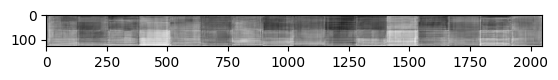

In [26]:
generator = Generator()
discriminator = Discriminator()
encoder = Encoder()
# generator, encoder, discriminator = load_models_of_same_batch(generator, encoder, discriminator, filename_prefix="main_model/model_snapshots/2023-07-13_21-45-53_bs32_lr1e-05_betas(0, 0.999)", epoch_number=9)
# with torch.no_grad():
#     for i in range(10):
#         noise = torch.randn(1, 128)
#         a = line_transcription_dataset_train[0]
#         embedding = encoder(a.unsqueeze(0))
#         print(embedding.shape)
#         image = generator(noise, embedding)
#         plt.imshow(image.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')
#         plt.savefig(f'test{i}.png')

cpu
fid load image_count 32
fid load image_count 64
fid load image_count 96
fid load image_count 100
epoch 0 batch 0
real_image_batch.shape torch.Size([32, 1, 128, 2048])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 128]) torch.Size([32, 256])


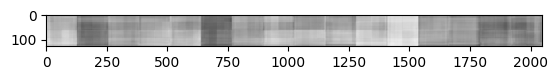

tensor([[3.6176e-03],
        [1.0460e-03],
        [1.0912e-02],
        [7.0640e-04],
        [2.0493e-03],
        [2.9972e-04],
        [2.3999e-03],
        [1.5047e-03],
        [1.5735e-03],
        [9.8655e-04],
        [1.9400e-03],
        [7.8270e-02],
        [2.4779e-03],
        [4.4139e-05],
        [8.2003e-02],
        [1.9184e-03],
        [9.2416e-06],
        [1.1930e-05],
        [1.3766e-02],
        [2.2236e-03],
        [8.0498e-05],
        [1.2459e-02],
        [1.3595e-05],
        [4.8957e-05],
        [6.2914e-03],
        [1.9551e-03],
        [2.2943e-04],
        [1.9835e-02],
        [9.5221e-05],
        [7.1290e-03],
        [9.7053e-04],
        [5.6050e-02]], grad_fn=<SigmoidBackward0>)
tensor([[7.6561e-06],
        [1.1596e-04],
        [7.6797e-06],
        [8.1863e-04],
        [7.0512e-04],
        [1.0458e-03],
        [2.5841e-06],
        [9.5883e-05],
        [9.5447e-07],
        [2.5805e-06],
        [4.2688e-05],
        [8.7314e-07],
   

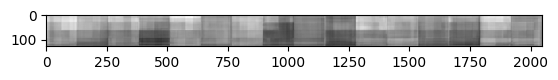

tensor([[0.0338],
        [0.0018],
        [0.1851],
        [0.2482],
        [0.0266],
        [0.0546],
        [0.0648],
        [0.0556],
        [0.0033],
        [0.9994],
        [0.9839],
        [0.0233],
        [0.0032],
        [0.0635],
        [0.0731],
        [0.0984],
        [0.0042],
        [0.1068],
        [0.0044],
        [0.0282],
        [0.0101],
        [0.1334],
        [0.0023],
        [0.4463],
        [0.0190],
        [0.0019],
        [0.9976],
        [0.9713],
        [0.0295],
        [0.0193],
        [0.1200],
        [0.9709]], grad_fn=<SigmoidBackward0>)
tensor([[9.9999e-01],
        [5.5203e-02],
        [6.5912e-01],
        [2.0471e-03],
        [9.8974e-01],
        [7.2571e-03],
        [2.1400e-02],
        [3.3685e-02],
        [3.5205e-01],
        [2.4466e-01],
        [2.8938e-02],
        [8.0526e-02],
        [2.5704e-03],
        [4.8604e-03],
        [2.0236e-02],
        [1.0509e-03],
        [6.6961e-04],
        [5.0396e-04],

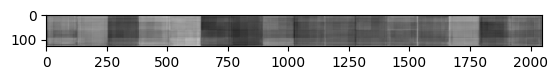

tensor([[0.5805],
        [0.9918],
        [0.4012],
        [0.8773],
        [0.2989],
        [0.7038],
        [0.4915],
        [0.2180],
        [0.0627],
        [0.1772],
        [0.4162],
        [0.8951],
        [0.8217],
        [0.9931],
        [0.1412],
        [0.3184],
        [0.3284],
        [0.1136],
        [0.8881],
        [0.5283],
        [0.4497],
        [0.5333],
        [0.0700],
        [0.4884],
        [0.3247],
        [0.7000],
        [0.3837],
        [0.6043],
        [0.3227],
        [0.4519],
        [0.4098],
        [0.3510]], grad_fn=<SigmoidBackward0>)
tensor([[0.5003],
        [0.9999],
        [0.1447],
        [0.2402],
        [0.6329],
        [0.7710],
        [0.1003],
        [0.1540],
        [0.9399],
        [0.9450],
        [0.3973],
        [0.1621],
        [0.4268],
        [0.1690],
        [0.1795],
        [0.9930],
        [0.8673],
        [0.4007],
        [0.3153],
        [0.1075],
        [0.3981],
        [0.0773],

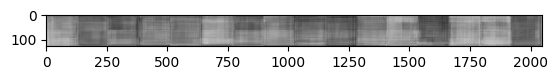

tensor([[0.2485],
        [0.3624],
        [0.1111],
        [0.3191]], grad_fn=<SigmoidBackward0>)
tensor([[0.2656],
        [0.5849],
        [0.3660],
        [0.8243]], grad_fn=<SigmoidBackward0>)
tensor(3)
tensor(0.3865, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.4938],
        [0.6769],
        [0.9686],
        [0.6582]], grad_fn=<SigmoidBackward0>)
Epoch 0:
	Generator and encoder train loss: 1.488865815103054
	Discriminator train loss: 4.396606981754303
	Generator and encoder train accuracy: 437.34442138671875
	Discriminator train accuracy: 0.4140625
	Generator and encoder val loss: 0.3432082235813141
	Discriminator val loss: 2.045320510864258
	Generator and encoder val accuracy: 452.9335632324219
	Discriminator val accuracy: 0.34375


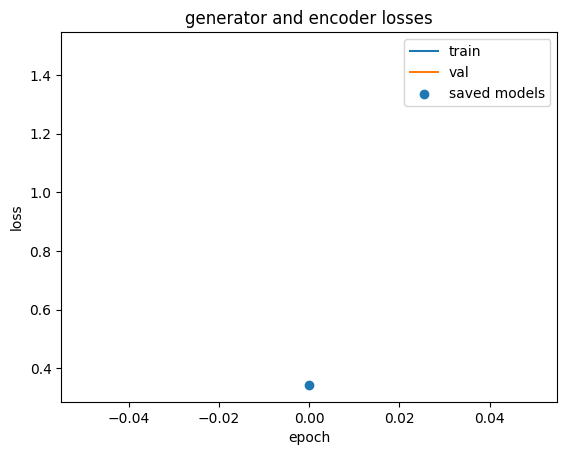

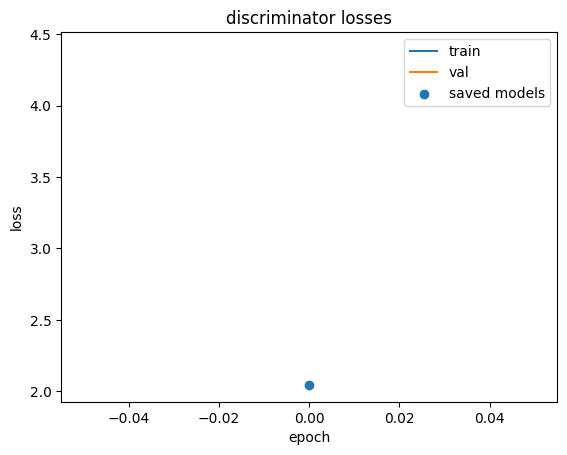

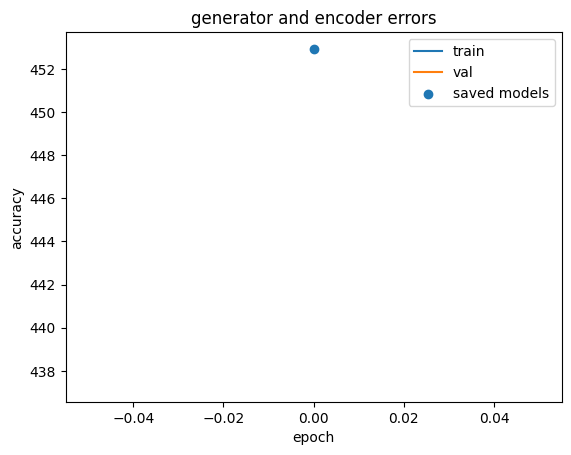

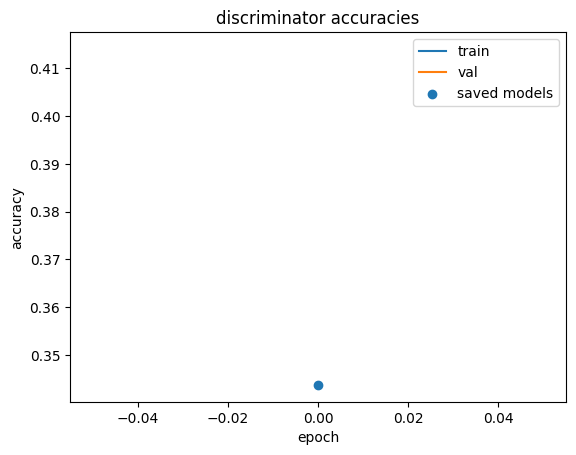

epoch 1 batch 0
real_image_batch.shape torch.Size([32, 1, 128, 2048])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 128]) torch.Size([32, 256])


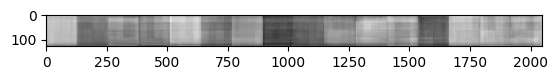

tensor([[0.9184],
        [0.6702],
        [0.6818],
        [0.6974],
        [0.7346],
        [0.6929],
        [0.4962],
        [0.9984],
        [0.7753],
        [0.9460],
        [0.8048],
        [0.4981],
        [0.8675],
        [0.9619],
        [0.6990],
        [0.6430],
        [0.8398],
        [0.9417],
        [0.2605],
        [0.9194],
        [0.8331],
        [0.8549],
        [0.4768],
        [0.9441],
        [0.7368],
        [0.4520],
        [0.9662],
        [0.8476],
        [0.5380],
        [0.9724],
        [0.8142],
        [0.9357]], grad_fn=<SigmoidBackward0>)
tensor([[0.9468],
        [0.9588],
        [0.9864],
        [0.9208],
        [0.9967],
        [0.9355],
        [0.9578],
        [0.9717],
        [0.8961],
        [0.9893],
        [0.9928],
        [0.9565],
        [0.9990],
        [0.9934],
        [0.9701],
        [0.9242],
        [0.9499],
        [0.9484],
        [0.9479],
        [0.7952],
        [0.9161],
        [0.7951],

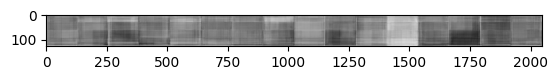

tensor([[0.2326],
        [0.3914],
        [0.0275],
        [0.4004],
        [0.0307],
        [0.1877],
        [0.8370],
        [0.4034],
        [0.0646],
        [0.3202],
        [0.3800],
        [0.3806],
        [0.3109],
        [0.5494],
        [0.0016],
        [0.0108],
        [0.2293],
        [0.6329],
        [0.3482],
        [0.2121],
        [0.1185],
        [0.4191],
        [0.4574],
        [0.1846],
        [0.0808],
        [0.1286],
        [0.1166],
        [0.0763],
        [0.0547],
        [0.0015],
        [0.0925],
        [0.4297]], grad_fn=<SigmoidBackward0>)
tensor([[8.0612e-01],
        [6.9545e-01],
        [7.6250e-01],
        [4.9723e-01],
        [2.7744e-01],
        [4.6391e-01],
        [5.4558e-05],
        [8.1696e-01],
        [7.6742e-01],
        [6.6439e-01],
        [6.7419e-01],
        [6.2329e-01],
        [7.4179e-01],
        [6.8070e-01],
        [4.6711e-01],
        [4.2125e-01],
        [7.9311e-01],
        [3.2762e-01],

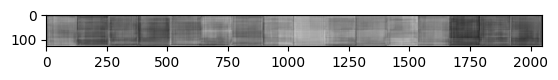

tensor([[0.3512],
        [0.4087],
        [0.9951],
        [0.4216],
        [0.3871],
        [0.1961],
        [0.4986],
        [0.5217],
        [0.4104],
        [0.5642],
        [0.4287],
        [0.1048],
        [0.7228],
        [0.3359],
        [0.6811],
        [0.4478],
        [0.1844],
        [0.2781],
        [0.3601],
        [0.3153],
        [0.2966],
        [0.1993],
        [0.9997],
        [1.0000],
        [0.2767],
        [0.3886],
        [0.5287],
        [0.3049],
        [0.5867],
        [0.2536],
        [0.2916],
        [0.9472]], grad_fn=<SigmoidBackward0>)
tensor([[0.9855],
        [0.8127],
        [0.6175],
        [0.8948],
        [0.9649],
        [0.9238],
        [0.8811],
        [0.7566],
        [0.9624],
        [0.9936],
        [0.9328],
        [0.8554],
        [0.8432],
        [0.9991],
        [0.9652],
        [0.6005],
        [0.9935],
        [0.6857],
        [0.8348],
        [0.6649],
        [0.9973],
        [0.8787],

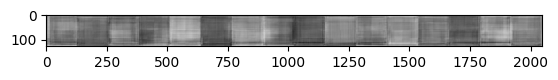

tensor([[0.1660],
        [0.1711],
        [0.2007],
        [0.0199]], grad_fn=<SigmoidBackward0>)
tensor([[0.3468],
        [0.7293],
        [0.3991],
        [0.2904]], grad_fn=<SigmoidBackward0>)
tensor(4)
tensor(0.3829, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.8389],
        [0.6055],
        [0.7061],
        [0.6028]], grad_fn=<SigmoidBackward0>)
Epoch 1:
	Generator and encoder train loss: 1.4637806862592697
	Discriminator train loss: 1.4549109935760498
	Generator and encoder train accuracy: 447.78204345703125
	Discriminator train accuracy: 0.5703125
	Generator and encoder val loss: 0.6208459734916687
	Discriminator val loss: 1.3303691148757935
	Generator and encoder val accuracy: 472.3376770019531
	Discriminator val accuracy: 0.390625


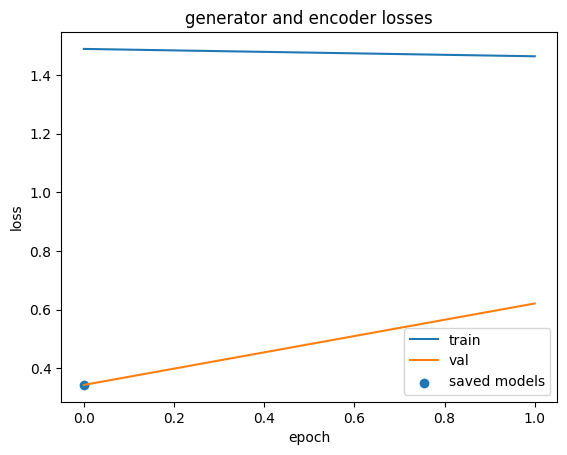

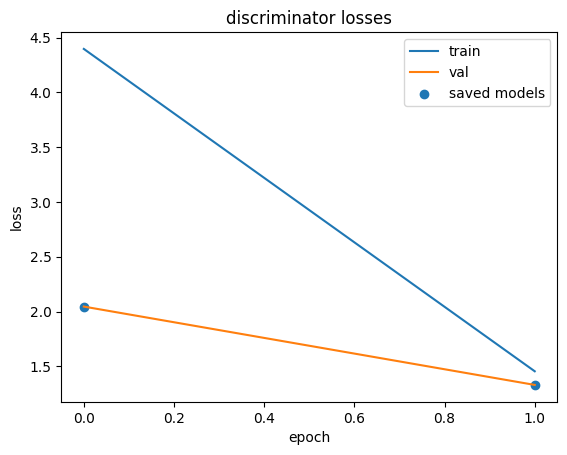

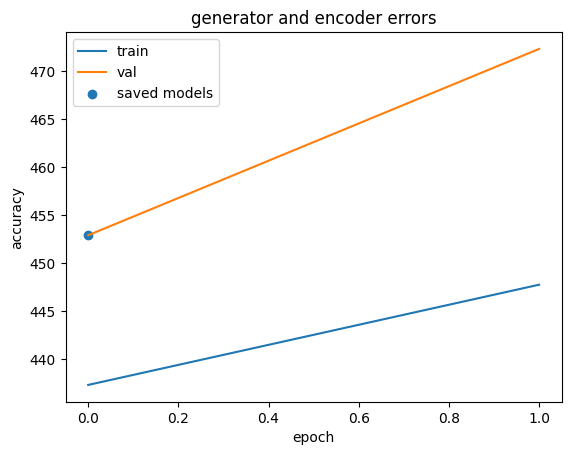

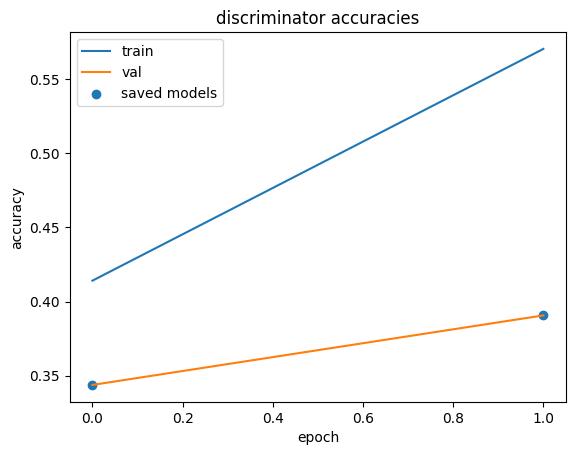

epoch 2 batch 0
real_image_batch.shape torch.Size([32, 1, 128, 2048])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 128]) torch.Size([32, 256])


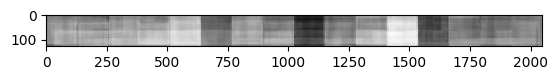

tensor([[0.6159],
        [0.4376],
        [0.6799],
        [0.6755],
        [0.4199],
        [0.3918],
        [0.5005],
        [0.8223],
        [0.9779],
        [0.7694],
        [0.4165],
        [0.3874],
        [0.1883],
        [0.7377],
        [0.4063],
        [0.4244],
        [0.4588],
        [0.3403],
        [0.7271],
        [0.5704],
        [0.5645],
        [0.5726],
        [0.6642],
        [0.6735],
        [0.8180],
        [0.6192],
        [0.5410],
        [0.7298],
        [0.2138],
        [0.7409],
        [0.7289],
        [0.6949]], grad_fn=<SigmoidBackward0>)
tensor([[0.9715],
        [0.9564],
        [0.9740],
        [0.9650],
        [0.9840],
        [0.8790],
        [0.9883],
        [0.9505],
        [0.9496],
        [0.9812],
        [0.9794],
        [0.9456],
        [0.8340],
        [0.9869],
        [0.8714],
        [0.9978],
        [0.9578],
        [0.8825],
        [0.9476],
        [0.9518],
        [0.9646],
        [0.9807],

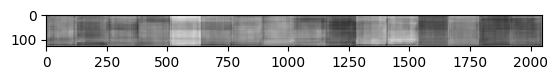

tensor([[1.3053e-01],
        [2.9895e-02],
        [6.9548e-02],
        [9.1333e-02],
        [1.3201e-01],
        [7.0723e-02],
        [4.9333e-02],
        [1.6261e-01],
        [1.8687e-01],
        [2.8244e-02],
        [3.4502e-01],
        [8.8104e-03],
        [2.2109e-01],
        [7.5522e-02],
        [8.8464e-02],
        [7.0645e-02],
        [3.0984e-02],
        [1.4796e-01],
        [1.8656e-02],
        [5.0168e-02],
        [2.6773e-03],
        [3.2727e-01],
        [9.8286e-02],
        [6.3177e-02],
        [3.3723e-02],
        [1.6485e-02],
        [7.4973e-02],
        [5.5916e-02],
        [1.7683e-01],
        [5.5883e-05],
        [4.8237e-02],
        [5.5014e-02]], grad_fn=<SigmoidBackward0>)
tensor([[0.5405],
        [0.3895],
        [0.4183],
        [0.6006],
        [0.8196],
        [0.1002],
        [0.9141],
        [0.3538],
        [0.1920],
        [0.3997],
        [0.0494],
        [0.5469],
        [0.8821],
        [0.1919],
        [0.6007

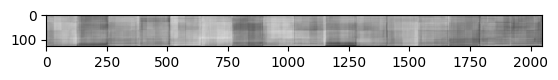

tensor([[0.7098],
        [0.7347],
        [0.5711],
        [0.8751],
        [0.5381],
        [0.5876],
        [0.8730],
        [0.3025],
        [0.2181],
        [0.0485],
        [0.4401],
        [0.6261],
        [0.4943],
        [0.4782],
        [0.9057],
        [0.5390],
        [0.4862],
        [0.5984],
        [0.5262],
        [0.7447],
        [0.4758],
        [0.9804],
        [0.9592],
        [0.6201],
        [0.6825],
        [0.2109],
        [0.3986],
        [0.1908],
        [0.8483],
        [0.5136],
        [0.4110],
        [0.7309]], grad_fn=<SigmoidBackward0>)
tensor([[0.9594],
        [0.9801],
        [0.9958],
        [0.9886],
        [0.9539],
        [0.9381],
        [0.9639],
        [0.9588],
        [0.9787],
        [0.9699],
        [0.9445],
        [0.7819],
        [0.9780],
        [0.9893],
        [0.9661],
        [0.9944],
        [0.9908],
        [0.9663],
        [0.9965],
        [0.9882],
        [0.9934],
        [0.9682],

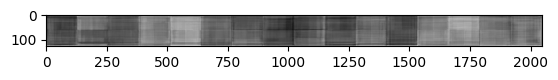

tensor([[0.0999],
        [0.0272],
        [0.0791],
        [0.0418]], grad_fn=<SigmoidBackward0>)
tensor([[0.6773],
        [0.4240],
        [0.4580],
        [0.6452]], grad_fn=<SigmoidBackward0>)
tensor(1)
tensor(1.0111, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.4026],
        [0.9000],
        [0.3094],
        [0.1563]], grad_fn=<SigmoidBackward0>)
Epoch 2:
	Generator and encoder train loss: 1.9844485819339752
	Discriminator train loss: 0.988384410738945
	Generator and encoder train accuracy: 434.6394348144531
	Discriminator train accuracy: 0.5625
	Generator and encoder val loss: 1.0474176406860352
	Discriminator val loss: 0.7908695340156555
	Generator and encoder val accuracy: 463.2122497558594
	Discriminator val accuracy: 0.5625


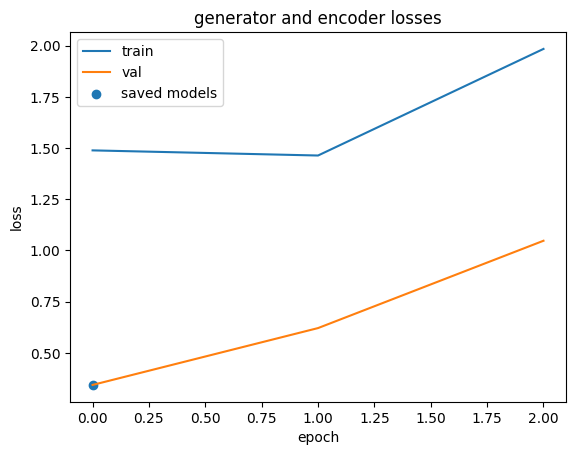

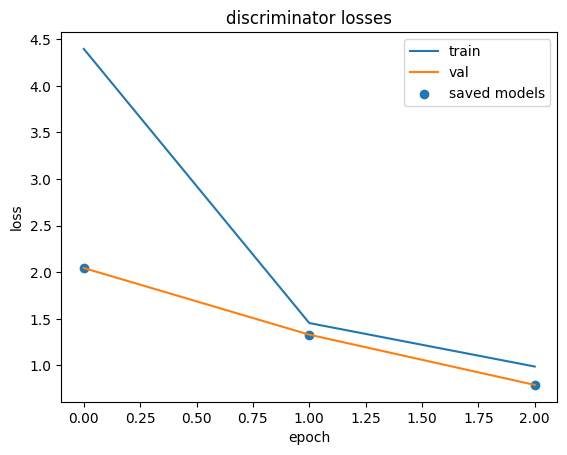

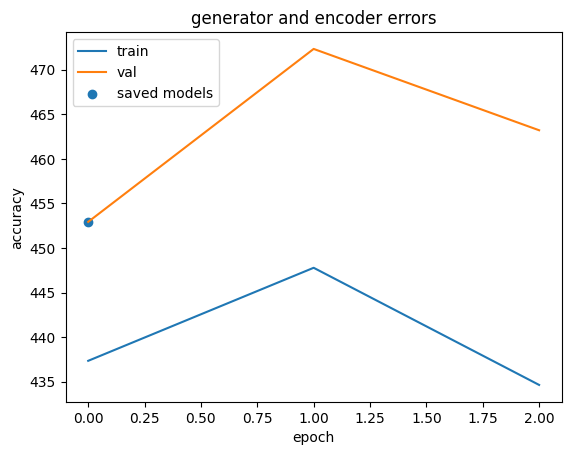

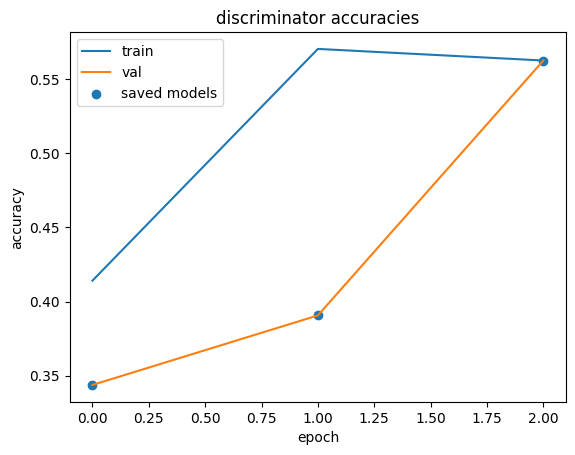

epoch 3 batch 0
real_image_batch.shape torch.Size([32, 1, 128, 2048])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 128]) torch.Size([32, 256])


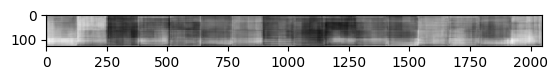

tensor([[0.5782],
        [0.4050],
        [0.0384],
        [0.1599],
        [0.4692],
        [0.4807],
        [0.4348],
        [0.3125],
        [0.4775],
        [0.3505],
        [0.7372],
        [0.2724],
        [0.3430],
        [0.1503],
        [0.1836],
        [0.3875],
        [0.3452],
        [0.3321],
        [0.3833],
        [0.1214],
        [0.5339],
        [0.4137],
        [0.2281],
        [0.9976],
        [0.3932],
        [0.0864],
        [0.4239],
        [0.3239],
        [0.8632],
        [0.2041],
        [0.9047],
        [0.3725]], grad_fn=<SigmoidBackward0>)
tensor([[0.9665],
        [0.9504],
        [0.8785],
        [0.9545],
        [0.9376],
        [0.8394],
        [0.7569],
        [0.9985],
        [0.9730],
        [0.9827],
        [0.9965],
        [0.9404],
        [0.9994],
        [0.9225],
        [0.9626],
        [0.9994],
        [0.9410],
        [0.9226],
        [0.9860],
        [0.9456],
        [0.9238],
        [0.8970],

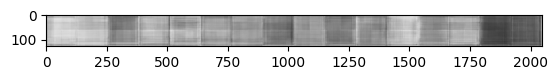

tensor([[0.1032],
        [0.0016],
        [0.0006],
        [0.0037],
        [0.1176],
        [0.0233],
        [0.0483],
        [0.1318],
        [0.0433],
        [0.0686],
        [0.0532],
        [0.1708],
        [0.0044],
        [0.0580],
        [0.0495],
        [0.0458],
        [0.0175],
        [0.0652],
        [0.0632],
        [0.0772],
        [0.0023],
        [0.0470],
        [0.1795],
        [0.0503],
        [0.0004],
        [0.0711],
        [0.0177],
        [0.1004],
        [0.3102],
        [0.0747],
        [0.1532],
        [0.0100]], grad_fn=<SigmoidBackward0>)
tensor([[0.8107],
        [0.1902],
        [0.9361],
        [0.4789],
        [0.6969],
        [0.6289],
        [0.4975],
        [0.2368],
        [0.7154],
        [0.4689],
        [0.2341],
        [0.6867],
        [0.9681],
        [0.8615],
        [0.7496],
        [0.4856],
        [0.5809],
        [0.9292],
        [0.7547],
        [0.6498],
        [0.3775],
        [0.5854],

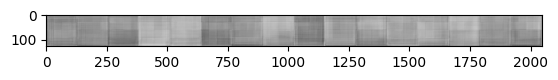

tensor([[0.1899],
        [0.4540],
        [0.2689],
        [0.3522],
        [0.4402],
        [0.2577],
        [0.2340],
        [0.9728],
        [0.1668],
        [0.1157],
        [0.3788],
        [0.7762],
        [0.3890],
        [0.2885],
        [0.5497],
        [0.3289],
        [0.1908],
        [0.3441],
        [0.5487],
        [0.3384],
        [0.2909],
        [0.4903],
        [0.3400],
        [0.5608],
        [0.1933],
        [0.3599],
        [0.2649],
        [0.1409],
        [0.1059],
        [0.3800],
        [0.4068],
        [0.5827]], grad_fn=<SigmoidBackward0>)
tensor([[0.9876],
        [0.9902],
        [0.9911],
        [0.9994],
        [0.9432],
        [0.9878],
        [0.9464],
        [0.8907],
        [0.9815],
        [0.9634],
        [0.9540],
        [0.9945],
        [0.9788],
        [0.9956],
        [0.9727],
        [0.9877],
        [0.9991],
        [0.9933],
        [0.9411],
        [0.9864],
        [0.9951],
        [0.9979],

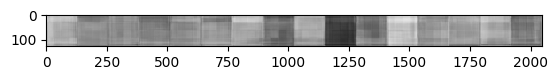

tensor([[0.1112],
        [0.0022],
        [0.0510],
        [0.0396]], grad_fn=<SigmoidBackward0>)
tensor([[0.9430],
        [0.2870],
        [0.7025],
        [0.7253]], grad_fn=<SigmoidBackward0>)
tensor(0)
tensor(1.4887, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.3748],
        [0.1805],
        [0.2223],
        [0.1725]], grad_fn=<SigmoidBackward0>)
Epoch 3:
	Generator and encoder train loss: 2.4604318737983704
	Discriminator train loss: 0.6787653863430023
	Generator and encoder train accuracy: 436.03790283203125
	Discriminator train accuracy: 0.69140625
	Generator and encoder val loss: 1.519811987876892
	Discriminator val loss: 0.4549831748008728
	Generator and encoder val accuracy: 456.5101013183594
	Discriminator val accuracy: 0.5625


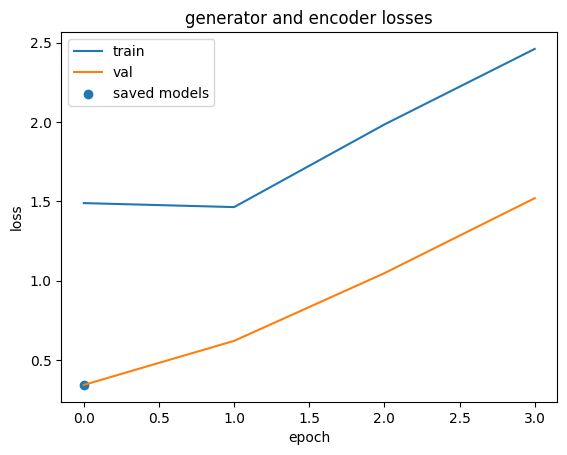

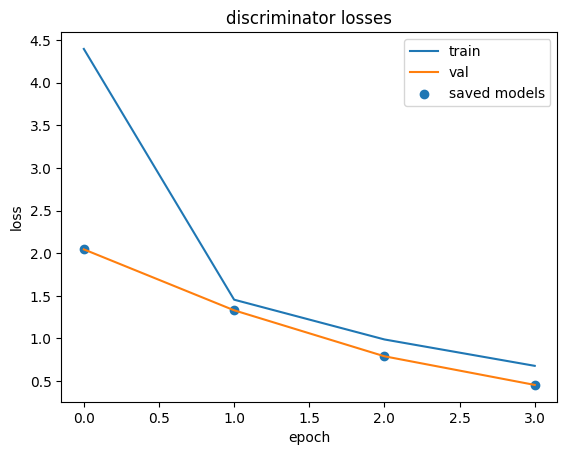

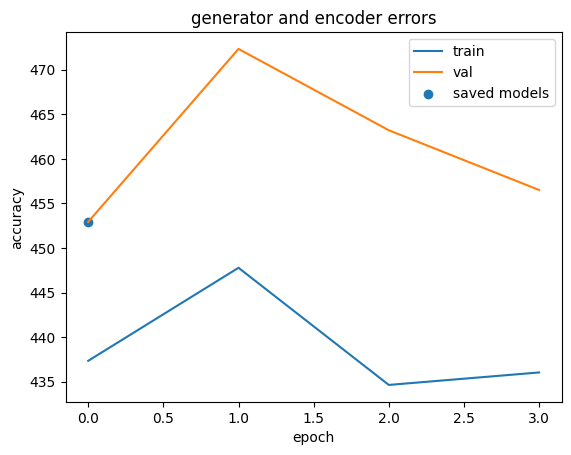

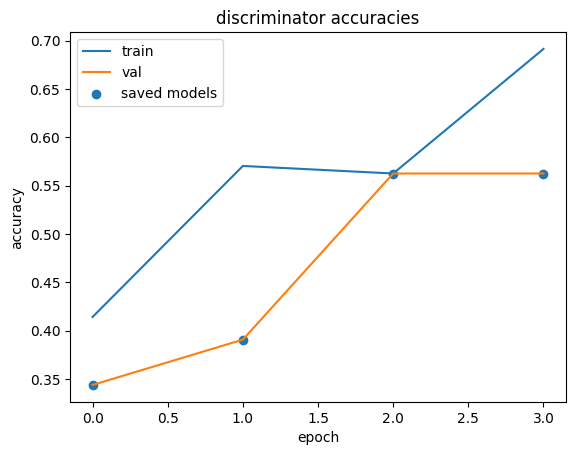

epoch 4 batch 0
real_image_batch.shape torch.Size([32, 1, 128, 2048])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 128]) torch.Size([32, 256])


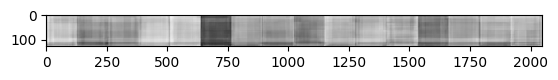

tensor([[0.3893],
        [0.0873],
        [0.1175],
        [0.3067],
        [0.2144],
        [0.2513],
        [0.4151],
        [0.2552],
        [0.5047],
        [0.4519],
        [0.0674],
        [0.2767],
        [0.8902],
        [0.0171],
        [0.0419],
        [0.2223],
        [0.2628],
        [0.3038],
        [0.3309],
        [0.1102],
        [0.2686],
        [0.2124],
        [0.4926],
        [0.0359],
        [0.2199],
        [0.2883],
        [0.2951],
        [0.4228],
        [0.1898],
        [0.1892],
        [0.1701],
        [0.1803]], grad_fn=<SigmoidBackward0>)
tensor([[0.9957],
        [0.9926],
        [0.7398],
        [0.9644],
        [0.9967],
        [0.9955],
        [0.9883],
        [0.9853],
        [0.9990],
        [0.9299],
        [0.9334],
        [0.9940],
        [0.9825],
        [0.9984],
        [0.9964],
        [0.9945],
        [0.9585],
        [0.9596],
        [0.9785],
        [0.8823],
        [0.9796],
        [0.8584],

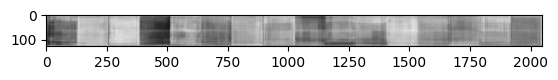

tensor([[1.7672e-03],
        [9.8315e-03],
        [1.6187e-02],
        [1.3193e-02],
        [6.0353e-02],
        [4.2573e-02],
        [8.7139e-03],
        [3.3914e-03],
        [6.7036e-03],
        [4.2303e-02],
        [1.7955e-05],
        [1.8783e-02],
        [2.5389e-02],
        [2.3897e-02],
        [1.4988e-02],
        [5.1021e-02],
        [8.7247e-02],
        [6.6349e-02],
        [1.9146e-02],
        [2.2672e-02],
        [5.8376e-02],
        [2.0055e-02],
        [6.3524e-03],
        [5.7865e-07],
        [3.8012e-02],
        [1.5415e-02],
        [1.1588e-01],
        [2.2787e-02],
        [1.9991e-02],
        [1.4949e-01],
        [1.2720e-02],
        [2.0694e-01]], grad_fn=<SigmoidBackward0>)
tensor([[0.5770],
        [0.7360],
        [0.8135],
        [0.8419],
        [0.9474],
        [0.5853],
        [0.8779],
        [0.7479],
        [0.8110],
        [0.9835],
        [0.7823],
        [0.2640],
        [0.1198],
        [0.8231],
        [0.8858

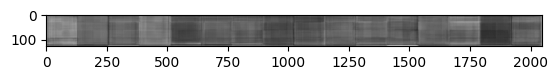

tensor([[0.0987],
        [0.0952],
        [0.2030],
        [0.1317],
        [0.0179],
        [0.3885],
        [0.1573],
        [0.1363],
        [0.1713],
        [0.5185],
        [0.1110],
        [0.0515],
        [0.0247],
        [0.1736],
        [0.4289],
        [0.2142],
        [0.2508],
        [0.1921],
        [0.1458],
        [0.2800],
        [0.1702],
        [0.1627],
        [0.2110],
        [0.0502],
        [0.3136],
        [0.1080],
        [0.0889],
        [0.1199],
        [0.1417],
        [0.3615],
        [0.2015],
        [0.2028]], grad_fn=<SigmoidBackward0>)
tensor([[0.9915],
        [0.9546],
        [0.9850],
        [0.9550],
        [0.9907],
        [0.9719],
        [0.9992],
        [0.9194],
        [0.9933],
        [0.9734],
        [0.8188],
        [0.9721],
        [0.9583],
        [0.9932],
        [0.9990],
        [0.9703],
        [0.9020],
        [0.9666],
        [0.9619],
        [0.9951],
        [0.9954],
        [0.9998],

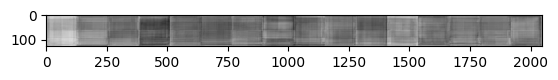

tensor([[0.0264],
        [0.0320],
        [0.0027],
        [0.0879]], grad_fn=<SigmoidBackward0>)
tensor([[0.7004],
        [0.5187],
        [0.8151],
        [0.6354]], grad_fn=<SigmoidBackward0>)
tensor(0)
tensor(1.3888, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.1982],
        [0.3753],
        [0.1312],
        [0.3960]], grad_fn=<SigmoidBackward0>)
Epoch 4:
	Generator and encoder train loss: 3.0911058485507965
	Discriminator train loss: 0.46622440218925476
	Generator and encoder train accuracy: 428.5531311035156
	Discriminator train accuracy: 0.74609375
	Generator and encoder val loss: 2.0346641540527344
	Discriminator val loss: 0.4335392415523529
	Generator and encoder val accuracy: 436.5760192871094
	Discriminator val accuracy: 0.609375


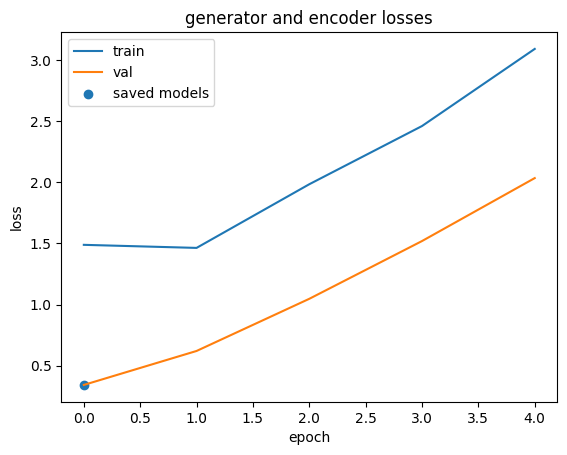

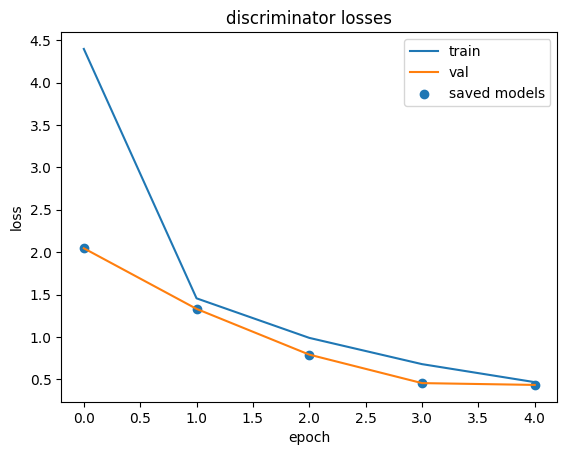

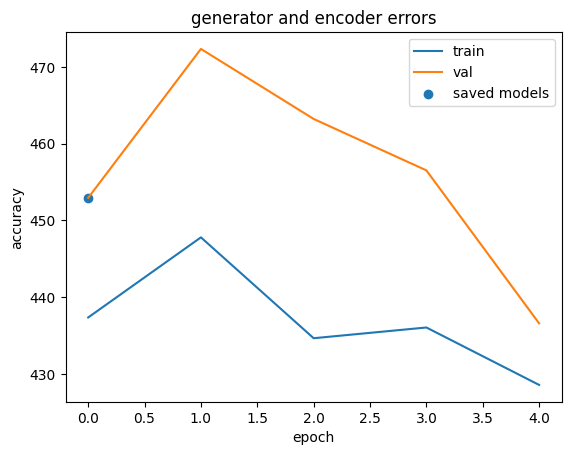

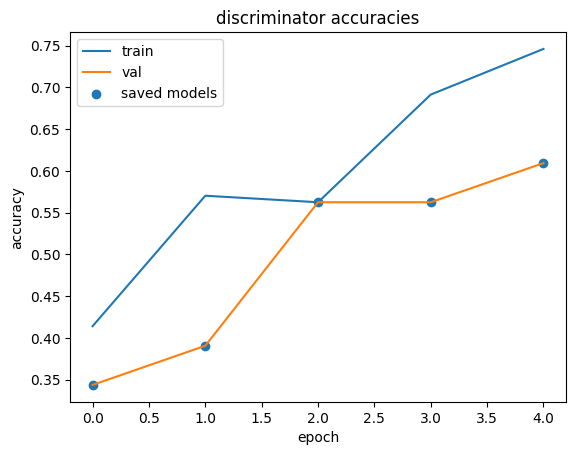

epoch 5 batch 0
real_image_batch.shape torch.Size([32, 1, 128, 2048])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 128]) torch.Size([32, 256])


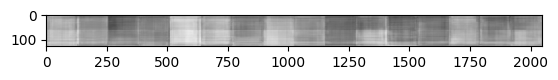

tensor([[0.4622],
        [0.1675],
        [0.1140],
        [0.2724],
        [0.5391],
        [0.1797],
        [0.1972],
        [0.4119],
        [0.1727],
        [0.0212],
        [0.0146],
        [0.3485],
        [0.0454],
        [0.3778],
        [0.5928],
        [0.3849],
        [0.1786],
        [0.3458],
        [0.1313],
        [0.2228],
        [0.0094],
        [0.7733],
        [0.0701],
        [0.4185],
        [0.3146],
        [0.4032],
        [0.1094],
        [0.1486],
        [0.1524],
        [0.0130],
        [0.1174],
        [0.1707]], grad_fn=<SigmoidBackward0>)
tensor([[0.9887],
        [0.9552],
        [0.8788],
        [0.9802],
        [0.9887],
        [0.9863],
        [0.9972],
        [0.9960],
        [0.9822],
        [0.9689],
        [0.9973],
        [0.9774],
        [0.9825],
        [0.9968],
        [0.9982],
        [0.9736],
        [0.9280],
        [0.9870],
        [0.9829],
        [0.9727],
        [0.9921],
        [0.9976],

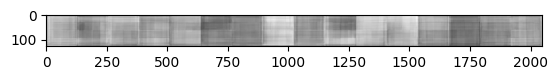

tensor([[5.9990e-02],
        [1.0975e-02],
        [3.5427e-03],
        [1.4514e-03],
        [1.1576e-03],
        [8.6317e-03],
        [2.4374e-02],
        [2.4220e-03],
        [6.0536e-02],
        [1.2570e-03],
        [3.0748e-04],
        [2.7390e-03],
        [5.1621e-03],
        [9.4251e-03],
        [3.5688e-04],
        [2.5554e-02],
        [1.0730e-03],
        [3.3823e-03],
        [2.0923e-01],
        [1.4108e-02],
        [8.6600e-03],
        [8.1774e-03],
        [4.6250e-03],
        [4.4843e-02],
        [1.3857e-04],
        [1.3534e-02],
        [1.5758e-02],
        [6.0751e-02],
        [4.0376e-03],
        [4.2938e-02],
        [1.9460e-02],
        [2.7805e-02]], grad_fn=<SigmoidBackward0>)
tensor([[0.9593],
        [0.8512],
        [0.8587],
        [0.9108],
        [0.9557],
        [0.9159],
        [0.8038],
        [0.8958],
        [0.1272],
        [0.8814],
        [0.9393],
        [0.8428],
        [0.7673],
        [0.7643],
        [0.8995

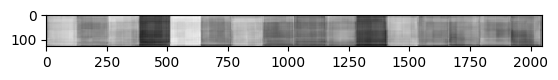

tensor([[0.2536],
        [0.0264],
        [0.0174],
        [0.9469],
        [0.1331],
        [0.7834],
        [0.3173],
        [0.1596],
        [0.0450],
        [0.0566],
        [0.4940],
        [0.0257],
        [0.0254],
        [0.0770],
        [0.0162],
        [0.0234],
        [0.0613],
        [0.0216],
        [0.0583],
        [0.2239],
        [0.0317],
        [0.0435],
        [0.1766],
        [0.8448],
        [0.0250],
        [0.2321],
        [0.0595],
        [0.0724],
        [0.0480],
        [0.3075],
        [0.0177],
        [0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.9931],
        [0.9995],
        [0.9785],
        [0.9866],
        [0.9905],
        [0.9660],
        [0.9929],
        [0.9888],
        [0.9959],
        [0.9914],
        [0.9709],
        [0.9952],
        [0.9979],
        [0.9902],
        [0.9841],
        [1.0000],
        [0.9949],
        [0.9853],
        [0.9794],
        [0.9915],
        [0.9560],
        [0.9974],

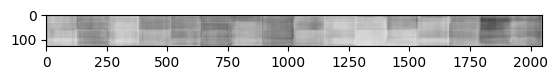

tensor([[0.0007],
        [0.1535],
        [0.0392],
        [0.0475]], grad_fn=<SigmoidBackward0>)
tensor([[0.8060],
        [0.6256],
        [0.7726],
        [0.9948]], grad_fn=<SigmoidBackward0>)
tensor(0)
tensor(2.0862, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0195],
        [0.3847],
        [0.1864],
        [0.1701]], grad_fn=<SigmoidBackward0>)
Epoch 5:
	Generator and encoder train loss: 3.4923744201660156
	Discriminator train loss: 0.3724512755870819
	Generator and encoder train accuracy: 435.5938720703125
	Discriminator train accuracy: 0.75
	Generator and encoder val loss: 2.3229897022247314
	Discriminator val loss: 0.26536428928375244
	Generator and encoder val accuracy: 434.9864807128906
	Discriminator val accuracy: 0.59375


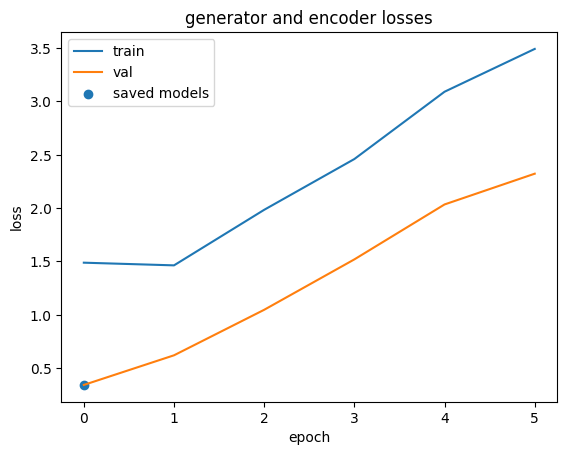

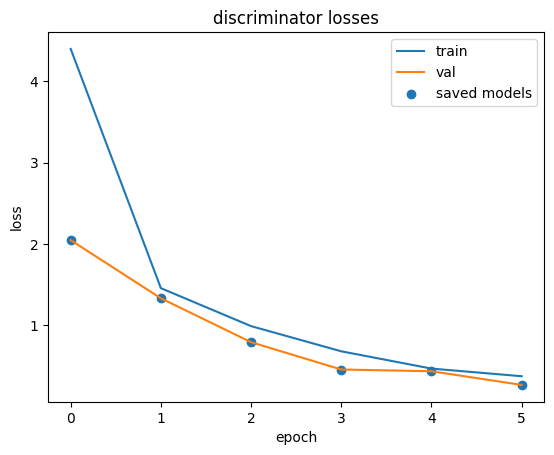

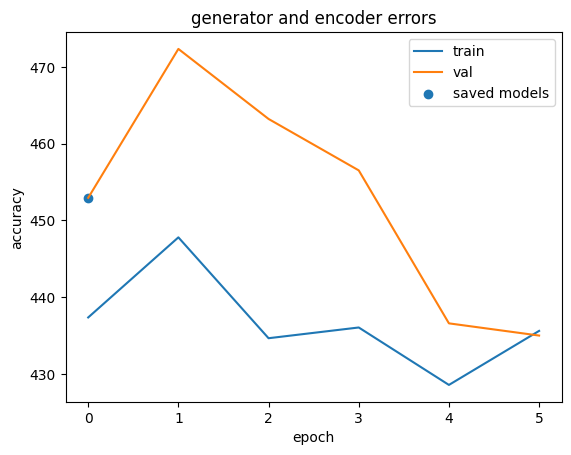

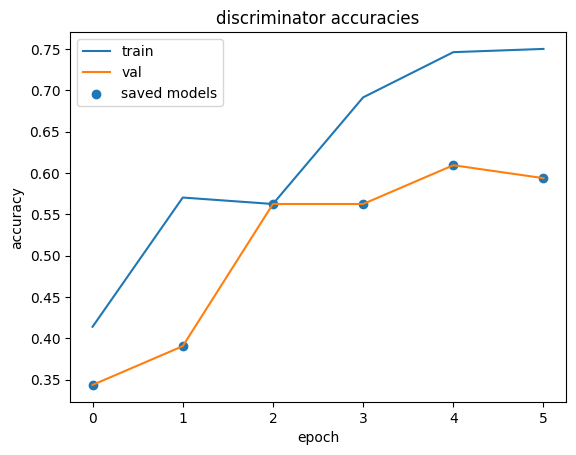

epoch 6 batch 0
real_image_batch.shape torch.Size([32, 1, 128, 2048])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 128]) torch.Size([32, 256])


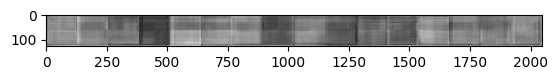

tensor([[1.9797e-01],
        [2.2350e-01],
        [5.1515e-02],
        [6.2662e-03],
        [2.0099e-02],
        [1.9591e-03],
        [1.7364e-01],
        [2.2204e-01],
        [1.2186e-01],
        [2.9209e-01],
        [1.9918e-01],
        [8.4016e-02],
        [4.5304e-02],
        [8.4711e-02],
        [1.7896e-01],
        [1.7399e-01],
        [1.0180e-01],
        [3.0893e-02],
        [1.3898e-05],
        [2.0614e-01],
        [1.5850e-01],
        [1.4822e-01],
        [4.3962e-02],
        [1.8946e-01],
        [1.0758e-01],
        [3.1905e-02],
        [9.4632e-02],
        [1.8650e-01],
        [1.8139e-01],
        [3.3142e-01],
        [2.7169e-01],
        [2.6929e-01]], grad_fn=<SigmoidBackward0>)
tensor([[0.9981],
        [0.9931],
        [0.9970],
        [0.9978],
        [0.9817],
        [0.9896],
        [0.9994],
        [0.9961],
        [0.9837],
        [0.9371],
        [0.9892],
        [0.9776],
        [0.9999],
        [0.9977],
        [0.9909

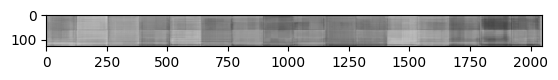

tensor([[3.9800e-03],
        [1.0826e-03],
        [6.6782e-03],
        [7.8134e-03],
        [1.1647e-02],
        [8.4255e-04],
        [2.9413e-04],
        [2.4367e-03],
        [3.0468e-02],
        [5.9516e-03],
        [3.4905e-02],
        [1.6848e-02],
        [3.3645e-03],
        [1.1404e-02],
        [3.0288e-03],
        [3.7622e-03],
        [2.1728e-03],
        [6.8318e-03],
        [2.7847e-02],
        [8.6483e-03],
        [3.2490e-02],
        [6.1414e-03],
        [3.3026e-03],
        [9.8405e-03],
        [4.7281e-02],
        [2.2778e-02],
        [2.8431e-03],
        [2.1466e-03],
        [4.8487e-05],
        [9.7579e-03],
        [1.0641e-02],
        [4.7970e-03]], grad_fn=<SigmoidBackward0>)
tensor([[0.9581],
        [0.9440],
        [0.5028],
        [0.9824],
        [0.9839],
        [0.8879],
        [0.8572],
        [0.7393],
        [0.7543],
        [0.8640],
        [0.9412],
        [0.9890],
        [0.4164],
        [0.9607],
        [0.9464

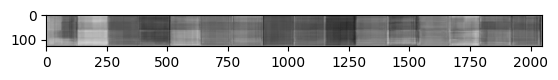

tensor([[0.0129],
        [0.0430],
        [0.0230],
        [0.4165],
        [0.2523],
        [0.2589],
        [0.5358],
        [0.0273],
        [0.9941],
        [0.0093],
        [0.0967],
        [0.1630],
        [0.1270],
        [0.0382],
        [0.0317],
        [0.0506],
        [0.0270],
        [0.0230],
        [0.0587],
        [0.0165],
        [0.1367],
        [0.0228],
        [0.0339],
        [0.2204],
        [0.0925],
        [0.0323],
        [0.0115],
        [0.0155],
        [0.0557],
        [0.3133],
        [0.0071],
        [0.0154]], grad_fn=<SigmoidBackward0>)
tensor([[0.9974],
        [0.9966],
        [0.9918],
        [0.9919],
        [0.9991],
        [0.9786],
        [0.9931],
        [0.9972],
        [0.9985],
        [0.9994],
        [0.9825],
        [0.9881],
        [0.9927],
        [0.9990],
        [0.9995],
        [0.9864],
        [0.9969],
        [0.9861],
        [0.9963],
        [0.9985],
        [0.9903],
        [0.9993],

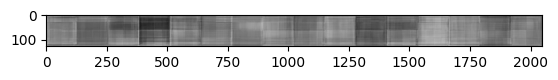

tensor([[0.0180],
        [0.0030],
        [0.0271],
        [0.0074]], grad_fn=<SigmoidBackward0>)
tensor([[0.9209],
        [0.9714],
        [0.9829],
        [0.9380]], grad_fn=<SigmoidBackward0>)
tensor(0)
tensor(2.3483, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0351],
        [0.1458],
        [0.0489],
        [0.3333]], grad_fn=<SigmoidBackward0>)
Epoch 6:
	Generator and encoder train loss: 3.7781278491020203
	Discriminator train loss: 0.25939618051052094
	Generator and encoder train accuracy: 432.44073486328125
	Discriminator train accuracy: 0.76953125
	Generator and encoder val loss: 1.9166377782821655
	Discriminator val loss: 0.21993465721607208
	Generator and encoder val accuracy: 453.99298095703125
	Discriminator val accuracy: 0.609375


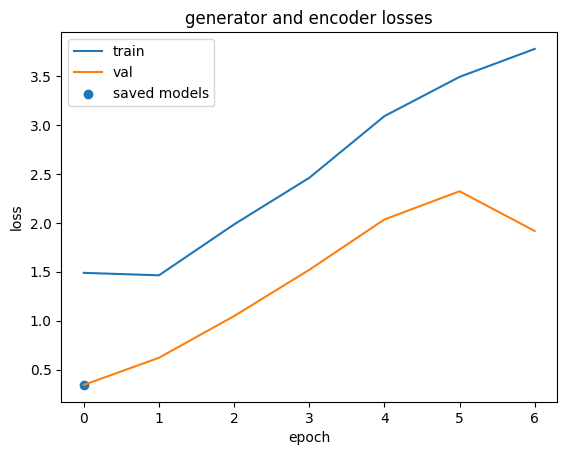

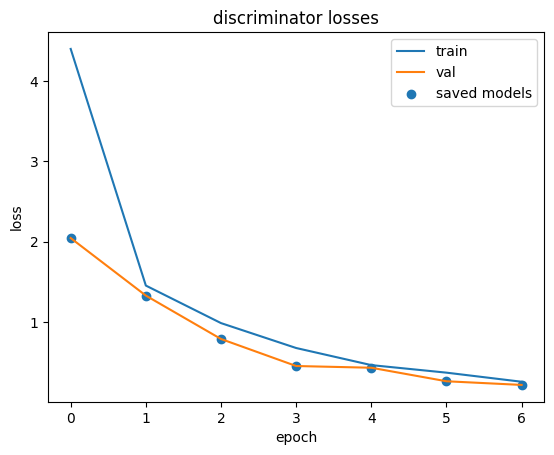

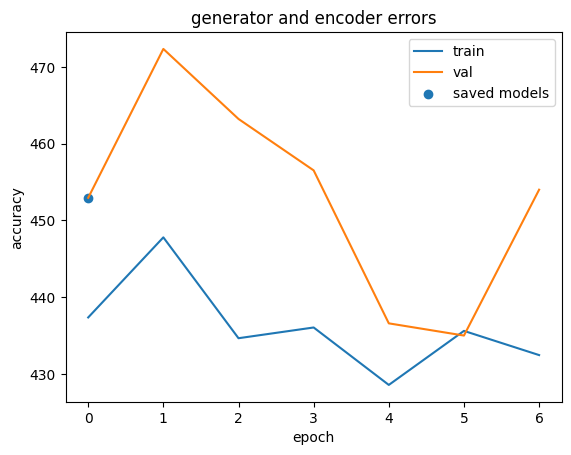

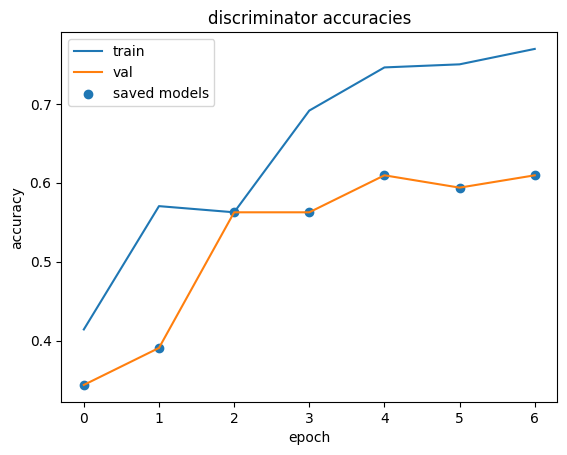

epoch 7 batch 0
real_image_batch.shape torch.Size([32, 1, 128, 2048])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 128]) torch.Size([32, 256])


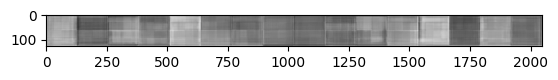

tensor([[2.6361e-01],
        [4.5149e-01],
        [3.2421e-01],
        [1.4810e-01],
        [1.4498e-01],
        [4.2200e-02],
        [8.6853e-05],
        [1.2536e-01],
        [7.1476e-02],
        [3.1227e-01],
        [1.6228e-01],
        [7.1942e-02],
        [5.2731e-02],
        [2.8858e-01],
        [3.7454e-02],
        [6.0487e-02],
        [2.9581e-01],
        [1.1237e-01],
        [1.4198e-01],
        [6.7621e-02],
        [1.8490e-01],
        [8.5923e-02],
        [1.1801e-01],
        [2.2103e-01],
        [1.9164e-01],
        [1.3181e-01],
        [8.9960e-02],
        [4.3222e-02],
        [3.7412e-02],
        [5.8298e-02],
        [1.1462e-01],
        [1.3042e-01]], grad_fn=<SigmoidBackward0>)
tensor([[0.9995],
        [0.9977],
        [0.9886],
        [0.9868],
        [0.9990],
        [0.9997],
        [0.9993],
        [0.9979],
        [0.9973],
        [0.9930],
        [0.9928],
        [0.9997],
        [0.9984],
        [0.9972],
        [0.9941

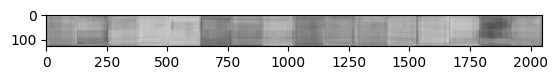

tensor([[6.1957e-04],
        [3.1984e-03],
        [7.0738e-10],
        [7.4670e-03],
        [6.2973e-03],
        [2.6623e-03],
        [5.2187e-03],
        [3.5404e-03],
        [1.8894e-02],
        [2.3934e-03],
        [4.2314e-03],
        [6.8903e-02],
        [8.8037e-03],
        [6.3249e-02],
        [7.9827e-02],
        [1.0661e-02],
        [9.7102e-03],
        [7.5265e-03],
        [7.6520e-03],
        [2.0405e-02],
        [3.2028e-02],
        [1.7719e-02],
        [2.4370e-02],
        [8.8077e-03],
        [1.5788e-02],
        [8.1828e-03],
        [1.1898e-02],
        [1.0114e-02],
        [6.2350e-03],
        [1.5588e-03],
        [1.4179e-02],
        [1.3654e-02]], grad_fn=<SigmoidBackward0>)
tensor([[0.9722],
        [0.9041],
        [0.9872],
        [0.8847],
        [0.8228],
        [0.7863],
        [0.9794],
        [0.9873],
        [0.9901],
        [0.9530],
        [0.9476],
        [0.9725],
        [0.9893],
        [0.9048],
        [0.9671

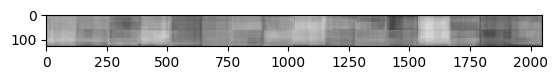

tensor([[0.0450],
        [0.4015],
        [0.0630],
        [0.0746],
        [0.0804],
        [0.2785],
        [0.1548],
        [0.6883],
        [0.1833],
        [0.1184],
        [0.1021],
        [0.0544],
        [0.0424],
        [0.0604],
        [0.1115],
        [0.3781],
        [0.0362],
        [0.0820],
        [0.1192],
        [0.0512],
        [0.0354],
        [0.0571],
        [0.1374],
        [0.1317],
        [0.0268],
        [0.0957],
        [0.3591],
        [0.0606],
        [0.0614],
        [0.0323],
        [0.1328],
        [0.1414]], grad_fn=<SigmoidBackward0>)
tensor([[0.9984],
        [0.9962],
        [0.9939],
        [0.9977],
        [0.9950],
        [0.9987],
        [0.9928],
        [0.9935],
        [0.9970],
        [0.9991],
        [0.9998],
        [0.9955],
        [0.9881],
        [0.9994],
        [0.9938],
        [0.9978],
        [0.9988],
        [0.9956],
        [0.9971],
        [0.9998],
        [0.9989],
        [0.9988],

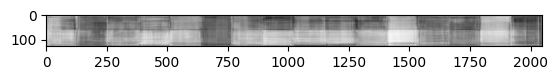

tensor([[1.0070e-04],
        [2.5335e-02],
        [3.1524e-02],
        [1.4036e-01]], grad_fn=<SigmoidBackward0>)
tensor([[0.9827],
        [0.9684],
        [0.9951],
        [0.9661]], grad_fn=<SigmoidBackward0>)
tensor(0)
tensor(5.8394, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0992],
        [0.0131],
        [0.0003],
        [0.0002]], grad_fn=<SigmoidBackward0>)
Epoch 7:
	Generator and encoder train loss: 4.689524531364441
	Discriminator train loss: 0.20631592348217964
	Generator and encoder train accuracy: 436.57525634765625
	Discriminator train accuracy: 0.77734375
	Generator and encoder val loss: 5.5425004959106445
	Discriminator val loss: 0.11138147115707397
	Generator and encoder val accuracy: 450.44781494140625
	Discriminator val accuracy: 0.625


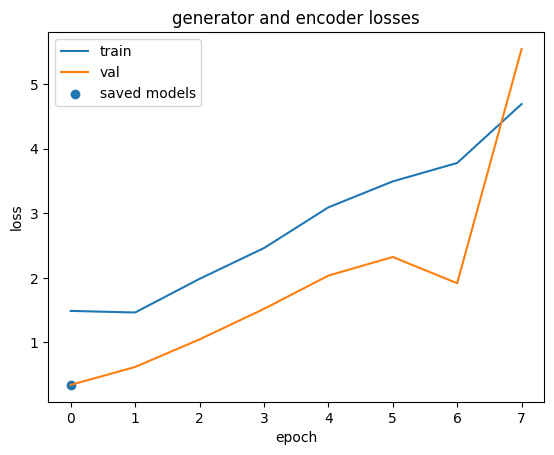

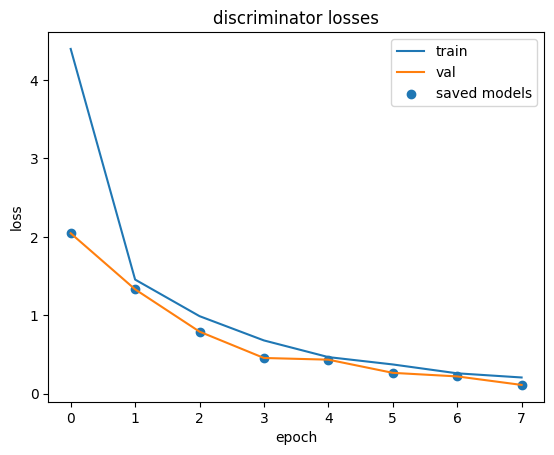

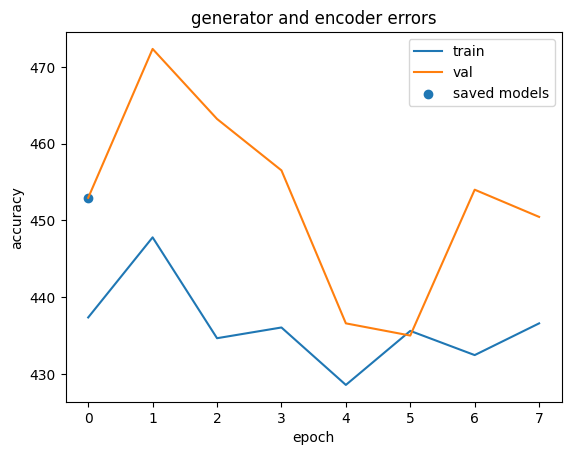

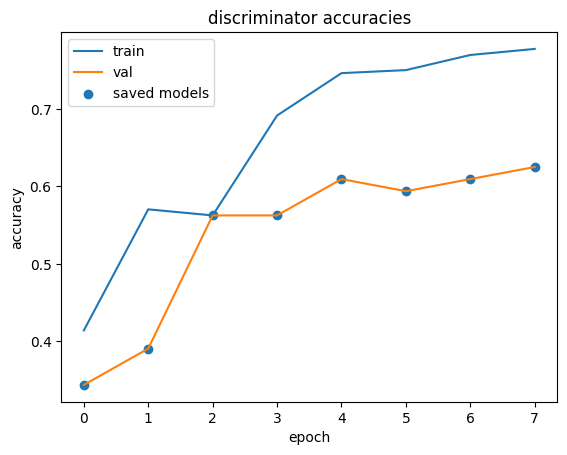

epoch 8 batch 0
real_image_batch.shape torch.Size([32, 1, 128, 2048])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 128]) torch.Size([32, 256])


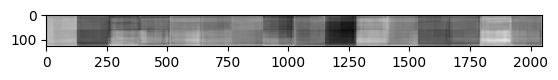

tensor([[2.3866e-03],
        [7.2522e-03],
        [1.0721e-02],
        [2.7074e-02],
        [8.4034e-03],
        [3.8735e-03],
        [4.8271e-03],
        [2.2980e-01],
        [3.6633e-02],
        [3.0019e-03],
        [2.5928e-03],
        [1.4878e-04],
        [2.7346e-04],
        [3.2456e-05],
        [2.6323e-02],
        [1.0899e-03],
        [8.1455e-04],
        [8.8079e-05],
        [3.4388e-03],
        [1.1979e-03],
        [3.0698e-03],
        [5.2159e-03],
        [3.3179e-04],
        [2.6452e-02],
        [1.5130e-04],
        [3.3433e-04],
        [1.3432e-02],
        [1.2431e-02],
        [3.4834e-04],
        [2.2387e-04],
        [1.3210e-03],
        [5.6390e-03]], grad_fn=<SigmoidBackward0>)
tensor([[0.9424],
        [0.9712],
        [0.9052],
        [0.8059],
        [0.9672],
        [0.9839],
        [0.9718],
        [0.1332],
        [0.9789],
        [0.9605],
        [0.9402],
        [0.8589],
        [0.9830],
        [0.9523],
        [0.9832

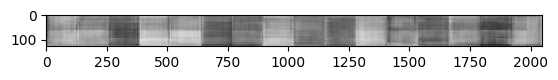

tensor([[0.0281],
        [0.0261],
        [0.0255],
        [0.0168],
        [0.1142],
        [0.0839],
        [0.3022],
        [0.0249],
        [0.0607],
        [0.0913],
        [0.0173],
        [0.0034],
        [0.0006],
        [0.4643],
        [0.0158],
        [0.2300],
        [0.0047],
        [0.1305],
        [0.0016],
        [0.0062],
        [0.0161],
        [0.0016],
        [0.1370],
        [0.0261],
        [0.0405],
        [0.0249],
        [0.0149],
        [0.0080],
        [0.0043],
        [0.1620],
        [0.0267],
        [0.0438]], grad_fn=<SigmoidBackward0>)
tensor([[0.9999],
        [0.9839],
        [0.9920],
        [0.9469],
        [0.9921],
        [0.9778],
        [0.9736],
        [0.9769],
        [0.9857],
        [0.9908],
        [0.9974],
        [0.9726],
        [0.9950],
        [0.9925],
        [0.9800],
        [0.9973],
        [1.0000],
        [0.9948],
        [0.9826],
        [0.9970],
        [0.9999],
        [0.9663],

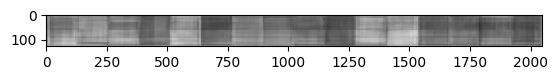

tensor([[1.4535e-03],
        [4.0348e-03],
        [2.2479e-03],
        [1.3277e-02],
        [3.3498e-03],
        [1.1279e-02],
        [5.6310e-03],
        [2.2122e-02],
        [1.2575e-03],
        [6.9084e-04],
        [2.2043e-03],
        [9.6723e-07],
        [3.5001e-02],
        [5.8234e-05],
        [7.7735e-03],
        [9.8913e-03],
        [6.1719e-03],
        [8.4196e-03],
        [1.1618e-02],
        [5.6905e-03],
        [1.8239e-02],
        [3.5223e-05],
        [1.8554e-03],
        [1.3106e-02],
        [8.2042e-03],
        [7.3521e-03],
        [3.2702e-06],
        [1.1289e-02],
        [5.8451e-03],
        [9.3145e-03],
        [6.2652e-06],
        [3.5624e-03]], grad_fn=<SigmoidBackward0>)
tensor([[0.9193],
        [0.8324],
        [0.9827],
        [0.9549],
        [0.6755],
        [0.9303],
        [0.6949],
        [0.9740],
        [0.9243],
        [0.8992],
        [0.8090],
        [0.9964],
        [0.8199],
        [0.6892],
        [0.9964

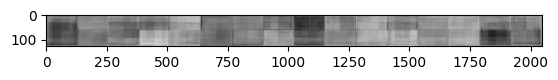

tensor([[0.0544],
        [0.0153],
        [0.3181],
        [0.0591]], grad_fn=<SigmoidBackward0>)
tensor([[0.9960],
        [0.9997],
        [0.9980],
        [0.9995]], grad_fn=<SigmoidBackward0>)
tensor(0)
tensor(5.7308, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0118],
        [0.0021],
        [0.0027],
        [0.0016]], grad_fn=<SigmoidBackward0>)
Epoch 8:
	Generator and encoder train loss: 4.811314940452576
	Discriminator train loss: 0.22285626083612442
	Generator and encoder train accuracy: 439.3618469238281
	Discriminator train accuracy: 0.77734375
	Generator and encoder val loss: 5.287240505218506
	Discriminator val loss: 0.05187229812145233
	Generator and encoder val accuracy: 436.66046142578125
	Discriminator val accuracy: 0.625


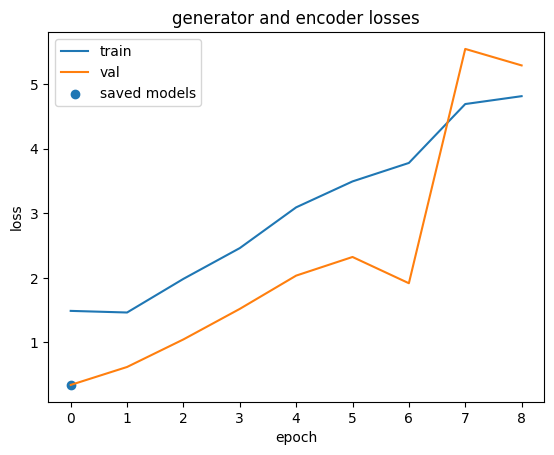

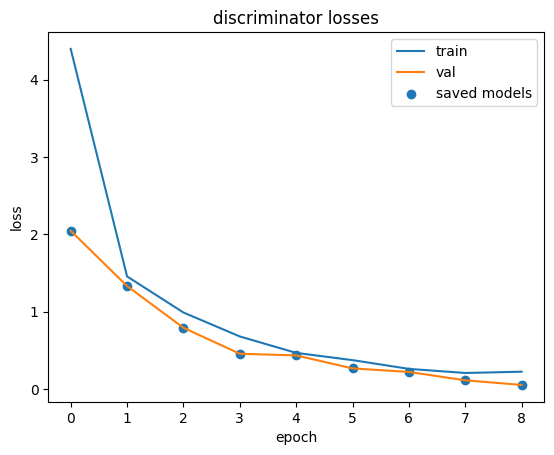

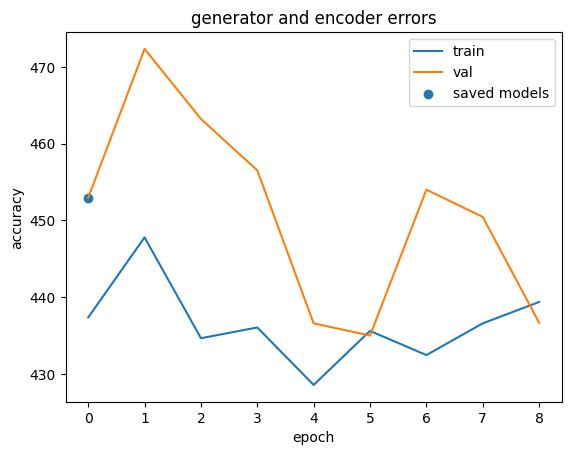

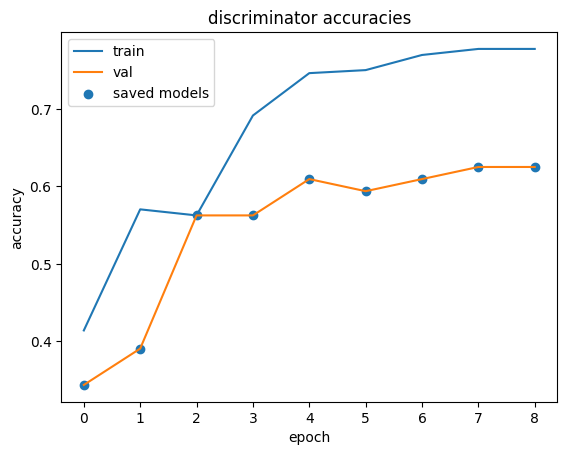

epoch 9 batch 0
real_image_batch.shape torch.Size([32, 1, 128, 2048])
input_text_batch.shape torch.Size([32, 82])
torch.Size([32, 128]) torch.Size([32, 256])


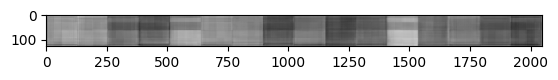

tensor([[2.2959e-04],
        [4.8136e-04],
        [1.3262e-03],
        [8.3698e-03],
        [1.7453e-03],
        [1.1515e-03],
        [3.6921e-02],
        [6.2058e-03],
        [1.3613e-02],
        [3.0433e-03],
        [5.7395e-03],
        [1.8453e-03],
        [2.5731e-03],
        [1.3912e-10],
        [5.6330e-05],
        [1.2629e-02],
        [2.7554e-02],
        [3.4591e-02],
        [2.7312e-02],
        [7.0582e-03],
        [5.6306e-03],
        [4.6473e-03],
        [1.1657e-04],
        [4.2624e-04],
        [7.9636e-04],
        [1.2851e-03],
        [9.2357e-02],
        [1.5544e-02],
        [2.8535e-03],
        [1.3508e-02],
        [4.7370e-03],
        [1.8883e-05]], grad_fn=<SigmoidBackward0>)
tensor([[0.9877],
        [0.9267],
        [0.8070],
        [0.9844],
        [0.8401],
        [0.8750],
        [0.8887],
        [0.9941],
        [0.9054],
        [0.9895],
        [0.9946],
        [0.9739],
        [0.8109],
        [0.9228],
        [0.9739

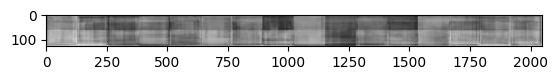

tensor([[5.4715e-02],
        [2.5539e-02],
        [5.0042e-02],
        [3.1994e-01],
        [5.8948e-02],
        [8.5657e-02],
        [4.2838e-04],
        [6.7372e-02],
        [5.4587e-02],
        [9.6293e-02],
        [5.9375e-04],
        [6.6357e-02],
        [5.9595e-01],
        [2.4498e-02],
        [3.5964e-02],
        [8.2211e-03],
        [9.3734e-02],
        [8.1562e-03],
        [1.0674e-01],
        [1.5392e-01],
        [6.3446e-02],
        [1.5010e-02],
        [1.3619e-01],
        [4.9041e-03],
        [2.2932e-01],
        [7.3954e-02],
        [1.6754e-02],
        [5.3259e-02],
        [2.8954e-02],
        [1.6908e-02],
        [7.5312e-03],
        [2.4224e-01]], grad_fn=<SigmoidBackward0>)
tensor([[0.9991],
        [0.9982],
        [0.9969],
        [0.9998],
        [0.9994],
        [0.9969],
        [0.9978],
        [0.9982],
        [0.9983],
        [0.9991],
        [0.9975],
        [0.9993],
        [0.9975],
        [0.9989],
        [0.9940

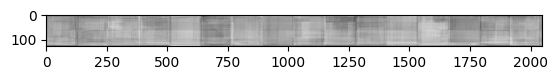

tensor([[1.4190e-07],
        [3.8631e-02],
        [4.6086e-04],
        [1.9707e-02],
        [3.7753e-02],
        [1.0336e-02],
        [1.2536e-02],
        [2.6342e-02],
        [1.3136e-04],
        [1.7904e-02],
        [3.9974e-02],
        [7.3260e-03],
        [2.8920e-03],
        [2.4497e-04],
        [8.0187e-04],
        [2.0396e-02],
        [3.3499e-03],
        [2.3099e-05],
        [2.3409e-02],
        [1.1762e-04],
        [1.9333e-02],
        [1.3936e-02],
        [2.7090e-02],
        [2.2438e-02],
        [3.5741e-03],
        [1.3813e-02],
        [2.4983e-02],
        [3.7617e-02],
        [2.5549e-02],
        [3.2573e-02],
        [4.1903e-02],
        [1.0490e-02]], grad_fn=<SigmoidBackward0>)
tensor([[0.9682],
        [0.9821],
        [0.9414],
        [0.9661],
        [0.9853],
        [0.9850],
        [0.9899],
        [0.9919],
        [0.9986],
        [0.9758],
        [0.9807],
        [0.9859],
        [0.9809],
        [0.9745],
        [0.9742

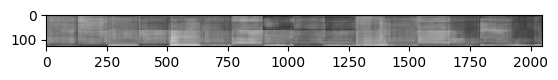

tensor([[0.0072],
        [0.1398],
        [0.0194],
        [0.0339]], grad_fn=<SigmoidBackward0>)
tensor([[0.9950],
        [0.9773],
        [0.9916],
        [0.9998]], grad_fn=<SigmoidBackward0>)
tensor(0)
tensor(6.0313, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[8.7528e-03],
        [4.5977e-05],
        [4.5630e-03],
        [1.8137e-02]], grad_fn=<SigmoidBackward0>)
Epoch 9:
	Generator and encoder train loss: 4.865556597709656
	Discriminator train loss: 0.1641257405281067
	Generator and encoder train accuracy: 437.49664306640625
	Discriminator train accuracy: 0.77734375
	Generator and encoder val loss: 6.394898891448975
	Discriminator val loss: 0.04592537507414818
	Generator and encoder val accuracy: 447.1327209472656
	Discriminator val accuracy: 0.625


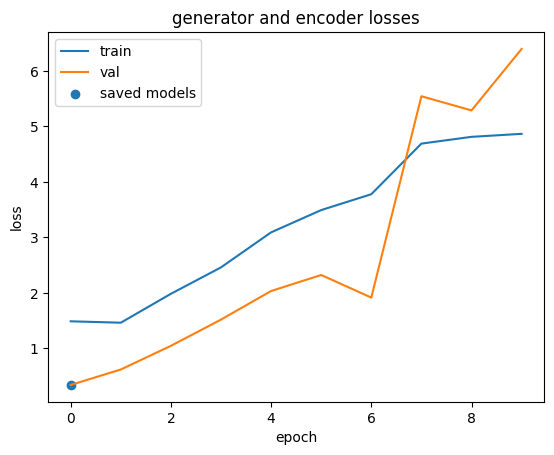

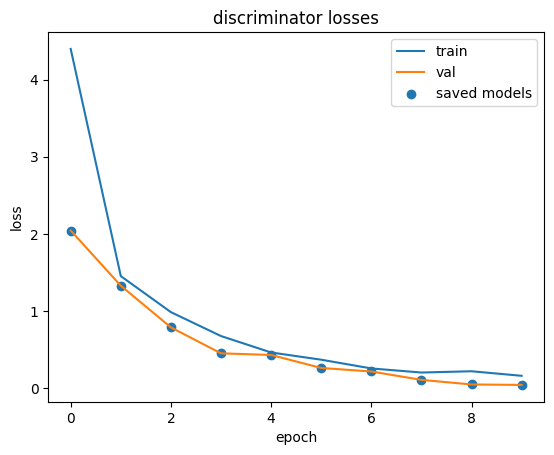

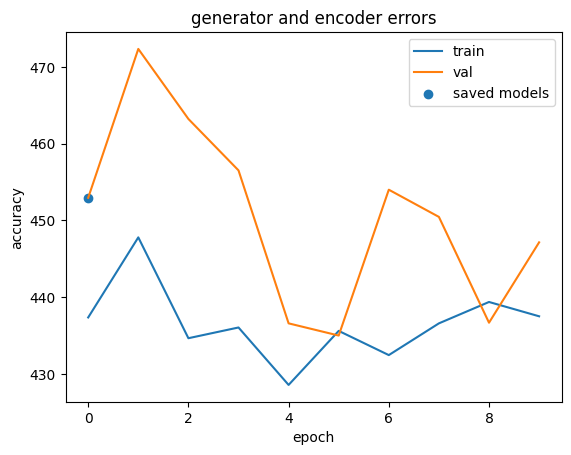

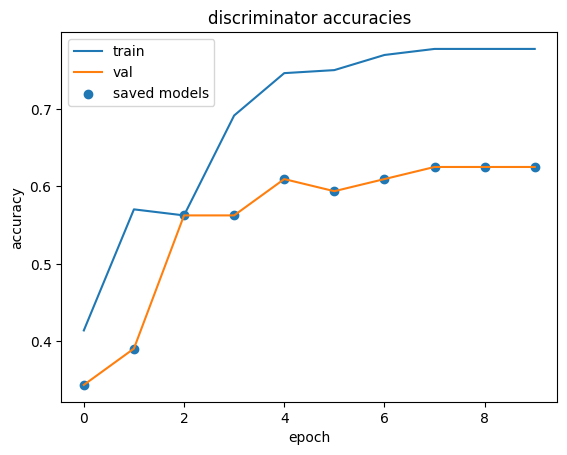

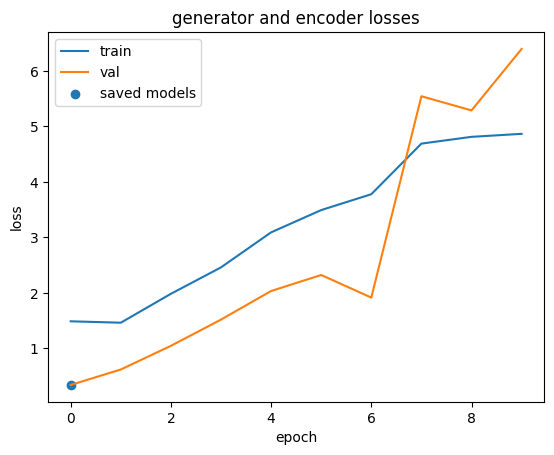

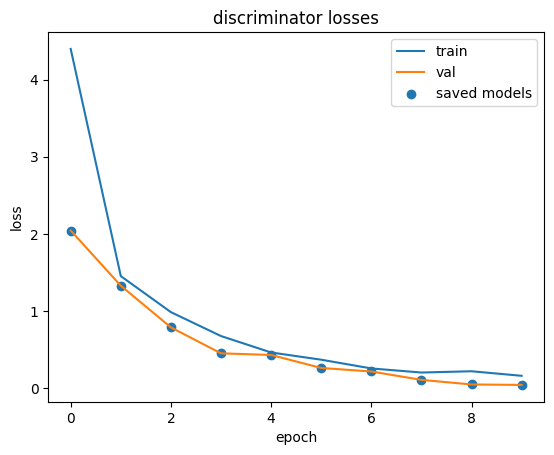

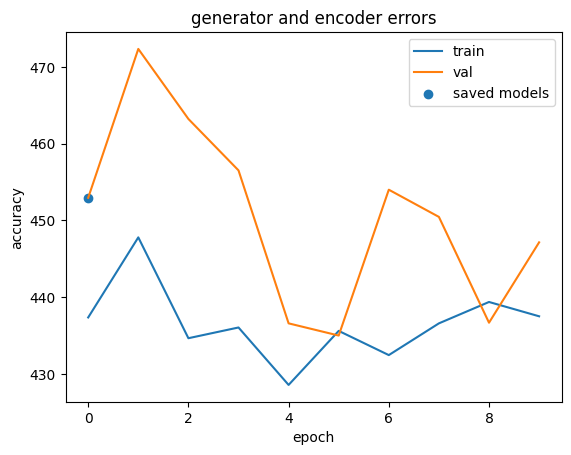

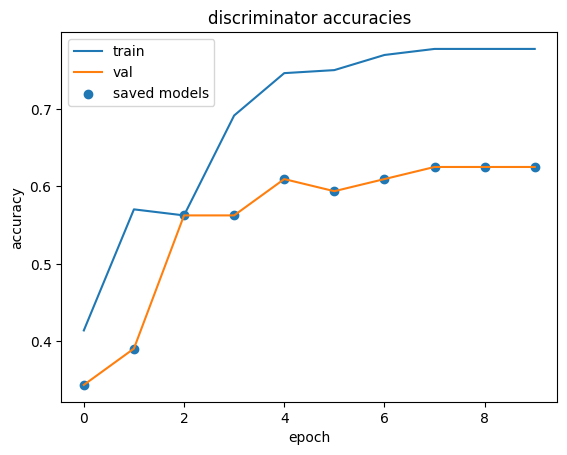

In [15]:
generator = Generator()
discriminator = Discriminator()
encoder = Encoder()
# generator = load_model(generator, "main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)_generator_epoch9.pt")
# generator, encoder, discriminator = load_models_of_same_batch(generator, encoder, discriminator, filename_prefix="main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)", epoch_number=9)

train_gan(learning_rate=1e-5, num_epochs=10, batch_size=32, encoder=encoder, generator=generator ,discriminator=discriminator, train_real_image_dataset=line_image_dataset_train, val_real_image_dataset=line_image_dataset_val, train_input_text_dataset=line_transcription_dataset_train, val_input_text_dataset=line_transcription_dataset_val, recognizer=None)